In [16]:
#!pip install imageio
#!pip install tifffile

In [1]:
# works
import tensorflow as tf

# 1. List all physical GPU devices.
gpus = tf.config.experimental.list_physical_devices('GPU')

if len(gpus) > 3:  # Ensure you have at least 4 GPUs.
    # 2. Use only GPU 2 and GPU 3.
    tf.config.experimental.set_visible_devices([gpus[1], gpus[2]], 'GPU')

    # 3. Set memory growth for GPU 1 and GPU 2.
    for gpu in [gpus[1], gpus[2]]:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("Not enough GPUs. Make sure you have at least 4 GPUs.")
strategy = tf.distribute.MirroredStrategy()  
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


**Part 1. Import libraries and define functions and models**

In [2]:
# imports
import cv2
import os
import math                 
import numpy as np
import rasterio
import rasterio.plot
from rasterio.windows import Window   
from rasterio.warp import reproject, Resampling     
import scipy.io as sio       
import matplotlib as plt     
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import netcdf as nc      
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import custom_object_scope
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
import datetime
from tensorflow.keras.models import save_model
from skimage.transform import resize
from tensorflow.keras.callbacks import LambdaCallback
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from skimage.transform import resize
import rasterio
from rasterio.plot import show
from shapely.geometry import box
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import models, layers, regularizers



**Model**

In [3]:

def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

def repeat_elem(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn
def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    FILTER_NUM = 64 
    FILTER_SIZE = 3 
    UP_SAMP_SIZE = 2 
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3
    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)
    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final) 
        # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model


In [4]:
input_shape = (512,512,3)
model=Attention_ResUNet(input_shape)
#model.summary()

**Define 3 different pixel-based metrics for binary semantic segmentation.**

In [5]:
# Pixel based metrics for binary semantic segmentation

smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

binary_iou = tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)

def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1_score_Loss(y_true, y_pred):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)   
    return 1. - score

def F1_score(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


**Attention: If you download the saved model (best_model_lake_512_512_2k_lake_2k_none_res_attention_fold_1.h5) and test_tiles_no_overlap from Google Drive, You can skip the below steps until Part 3.**

**Define data generator to read images and masks in batches.**

In [12]:


class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_paths, mask_paths, batch_size, img_dims, mask_dims):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_dims = img_dims
        self.mask_dims = mask_dims
        self.indexes = np.arange(len(self.img_paths))
        #print('inside generator image',self.img_paths[:3])  # Print first few paths when DataGenerator is initialized for sanity check
        #print('inside generator mask', self.mask_paths[:3])
        

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start:end]  # Use the shuffled/arranged indexes
        batch_img_paths = [self.img_paths[i] for i in batch_indexes]
        batch_mask_paths = [self.mask_paths[i] for i in batch_indexes]

        batch_images = [self._load_image(img_path) for img_path in batch_img_paths]
        batch_masks = [self._load_mask(mask_path) for mask_path in batch_mask_paths]
        #print("Reading image:", self.img_paths[index])  
        #print("Reading mask:", self.mask_paths[index])

        return np.array(batch_images), np.array(batch_masks)

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def _load_image(self, img_path):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        image = resize(image, self.img_dims, mode='constant', preserve_range=True)
        return image / 255.0

    def _load_mask(self, mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = resize(mask, self.mask_dims, mode='constant', preserve_range=True, order=0)
        mask = mask.astype(np.float32)
        #return np.expand_dims(mask, axis=-1)
        return mask


In [13]:

def read_files(input_dir,target_dir):

    input_img_paths = sorted(
        [
            os.path.join(input_dir, fname)
            for fname in os.listdir(input_dir)
            if fname.endswith(".tif")
        ]
    )
    target_img_paths = sorted(
        [
            os.path.join(target_dir, fname)
            for fname in os.listdir(target_dir)
            if fname.endswith(".tif") and not fname.startswith(".")
        ]
    )
    
    # print for sanity check
    #print("Number of samples:", len(input_img_paths))
    # print("Number of samples:", len(target_img_paths))
    for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
        
      #  print(input_path, "|", target_path)
       return input_img_paths, target_img_paths



**Model: 1**

Since the data is imbalanced, running the model on the whole train set is computationally expensive. So, this model is trained on 4k tiled images.

 1. 2k images their mask contain lake (1, 0-pixel values)+ randomly selecting 2K images their mask does not have lake (0) to train the model in filtered_2k_lake_2k_none_lake_train_tiles and filtered_2k_lake_2k_none_lake_mask_tiles folders. ( selecting and merging the data is done in the preprocessing step.)

Since it required making and reading different paths, the code is removed from this notebook to facilitate running this notebook. 

For generating these folders, refer to the preprocessing step.

Below paths to the train and test must be set:

selected_image_folder = 'filtered_2k_lake_2k_none_lake_train_tiles'

selected_mask_folder = 'filtered_2k_lake_2k_none_lake_mask_tiles'

In [270]:
# sanity check
import os

def count_files_in_directory(directory_path):
    return sum([1 for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])
# Destination folders
selected_image_folder = 'filtered_2k_lake_2k_none_lake_train_tiles'
selected_mask_folder = 'filtered_2k_lake_2k_none_lake_mask_tiles'

# Counting number of files in destination folders
num_images_in_selected_folder = count_files_in_directory(selected_image_folder)
num_masks_in_selected_folder = count_files_in_directory(selected_mask_folder)

print(f"Number of images in the tran folder: {num_images_in_selected_folder}")
print(f"Number of masks in the mask folder: {num_masks_in_selected_folder}")


Number of images in the tran folder: 4048
Number of masks in the mask folder: 4048


**End part 1.**

**There is no need to run the below cell**

**The below cell is just for a sanity check to check whether the images and mask are aligned. There is no need to run them.**

It requires defining the train and test paths:

Define the image and mask directories

image_folder = 'filtered_2k_lake_2k_none_lake_train_tiles'

mask_folder = 'filtered_2k_lake_2k_none_lake_mask_tiles'

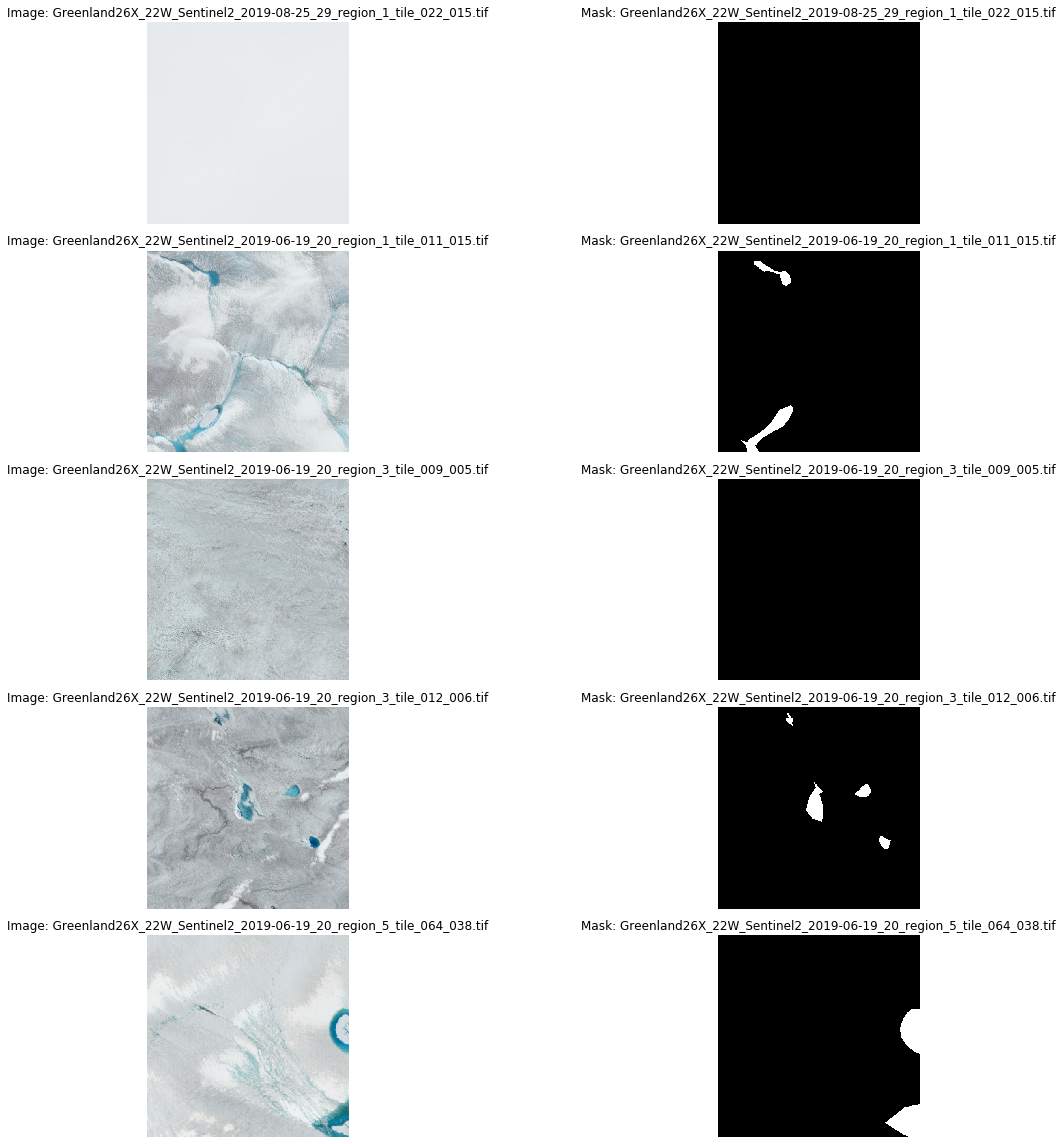

In [9]:
import os
import random
import matplotlib.pyplot as plt
from tifffile import imread  # For reading .tif files

# Define the image and mask directories
image_folder = 'filtered_2k_lake_2k_none_lake_train_tiles'
mask_folder = 'filtered_2k_lake_2k_none_lake_mask_tiles'

# Get all image filenames
all_images = [f for f in os.listdir(image_folder) if f.endswith('.tif')]

# Randomly select 5 images
selected_images = random.sample(all_images, 5)

# Plot the selected images and their corresponding masks
fig, axes = plt.subplots(5, 2, figsize=(16 ,16))  # 5 rows, 2 columns

for i, image_name in enumerate(selected_images):
    # Read image and its corresponding mask
    image_path = os.path.join(image_folder, image_name)
    mask_path = os.path.join(mask_folder, image_name)
    
    image = imread(image_path)
    mask = imread(mask_path)
    
    # Plot image and mask
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title(f"Image: {image_name}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title(f"Mask: {image_name}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


**Part 2. Train the model**

Below is the code for training the residual attention U-Net. The output path for saving each epoch's result in a.txt file must be set.

Like: output_file = "lake_512_512_2k_lake_2k_none_res_attention.txt"

Also, the train and mask paths for reading images and their masks must be set:

input_dir = 'filtered_2k_lake_2k_none_lake_train_tiles'

target_dir = 'filtered_2k_lake_2k_none_lake_mask_tiles'

The code uses 2-fold cross-validation with batch sizes 12 for 300 epochs. It saves the best model's weights before over fitting to be used for prediction and transfer learning.

In [13]:
output_file = "lake_512_512_2k_lake_2k_none_res_attention.txt"
input_dir = 'filtered_2k_lake_2k_none_lake_train_tiles'
target_dir = 'filtered_2k_lake_2k_none_lake_mask_tiles'


from tensorflow.keras.callbacks import LambdaCallback

def on_epoch_end(epoch, logs):
    message = (f'Epoch: {epoch+1}\n'
               f'Train loss: {logs["loss"]}\n'
               f'Train binary IOU: {logs["binary_iou"]}\n'
               f'Train dice coef: {logs["dice_coef"]}\n'
               f'Train F1: {logs["F1_score"]}\n'
               f'------------------------\n'
               f'Val loss: {logs["val_loss"]}\n'
               f'Val binary IOU: {logs["val_binary_iou"]}\n'
               f'Val dice coef: {logs["val_dice_coef"]}\n'
               f'Val F1: {logs["val_F1_score"]}\n'
               f'------------------------\n')
 
    save_to_file(message)

epoch_end_callback = LambdaCallback(on_epoch_end=on_epoch_end)

#output_file = "lake_512_512_2k_lake_2k_none_res_attention.txt"

def save_to_file(message):
    with open(output_file, "a") as file:
        file.write(message + "\n")

# Optional: clear the results file at the start of each run
with open(output_file, "w") as file:
    file.write("")


message = "Current Time = " + datetime.datetime.now().strftime("%H:%M:%S")
print(message)
save_to_file(message)

input_img_paths, target_img_paths = read_files(input_dir, target_dir)
train_img_paths, test_img_paths, train_mask_paths, test_mask_paths = train_test_split(input_img_paths, target_img_paths, test_size=0.2, random_state=42)


import random
num_folds = 2
batch_size = 12
history_list = []
epochs = 300

kf = KFold(n_splits=num_folds, shuffle=False)
# the below is just for a sanity check
#print("Train Image Paths:", train_img_paths[:5])  # Print the first 5 paths for brevity
#print("Train Mask Paths:",  train_mask_paths[:5])  # Print the first 5 paths for brevity


#images, masks = shuffle(input_img_paths,target_img_paths, random_state=0)
combined = list(zip(input_img_paths, target_img_paths))
random.shuffle(combined)
input_img_paths[:], target_img_paths[:] = zip(*combined)
# the below is just for a sanity check
#for _ in range(5):
  #  idx = random.randint(0, len(input_img_paths)-1)
    #print(input_img_paths[idx])
    #print(target_img_paths[idx])
#plot_image_mask(input_img_paths[0], target_img_paths[0])
#plot_image_mask(input_img_paths[2], target_img_paths[2])
#plot_image_mask(input_img_paths[10], target_img_paths[10])
#plot_image_mask(input_img_paths[20], target_img_paths[20])
# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(train_img_paths)):  # Notice the change here
    message = f'Fold {fold + 1}'
    print(message)
    save_to_file(message)


    # Split the data into train and validation sets for this fold
    train_images, val_images = np.array(train_img_paths)[train_index], np.array(train_img_paths)[val_index]  # Convert list to np.array
    train_masks, val_masks = np.array(train_mask_paths)[train_index], np.array(train_mask_paths)[val_index]  # Convert list to np.array


    img_dims = (512,512,3)
    mask_dims = (512,512,1)
    input_shape= (512,512,3)


    train_generator = DataGenerator(train_images, train_masks, batch_size=batch_size, img_dims=img_dims, mask_dims=mask_dims)
    
    val_generator = DataGenerator(val_images, val_masks, batch_size=batch_size, img_dims=img_dims, mask_dims=mask_dims)
    test_generator = DataGenerator(test_img_paths, test_mask_paths, batch_size=batch_size, img_dims=img_dims, mask_dims=mask_dims)
    #print(train_images.shape)
    #print(train_masks.shape)
    with strategy.scope():
        
        input_shape=(512,512,3)
        model=Attention_ResUNet(input_shape)

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
            # Compile the model
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss=dice_loss,
                        metrics=[binary_iou, dice_coef, F1_score])

    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1,  restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'best_model_lake_512_512_2k_lake_2k_none_res_attention_fold_{fold}.h5', monitor='val_dice_coef',mode='max', save_best_only=True, verbose=1)
   # lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=1e-6, patience=10, verbose=1, mode='min')
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=epochs,
                        callbacks=[early_stop, checkpoint, epoch_end_callback],
                        verbose=0)

    save_model(model, f'complete_model_lake_512_512_2k_lake_2k_none_res_attention_fold_{fold}.h5')
    history_list.append(history.history)
    model.load_weights(f'best_model_lake_512_512_2k_lake_2k_none_res_attention_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_generator)
    val_scores = model.evaluate(val_generator)
    test_scores = model.evaluate(test_generator)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    message = (f'Fold {fold+1}\n'
          f'Train loss: {train_scores[0]}\n'
          f'Train binary IOU: {train_scores[1]}\n'
          f'Train dice coef: {train_scores[2]}\n'
          f'Train F1: {train_scores[3]}\n'
          f'------------------------\n'
          f'Val loss: {val_scores[0]}\n'
          f'Val binary IOU: {val_scores[1]}\n'
          f'Val dice coef: {val_scores[2]}\n'
          f'Val F1: {val_scores[3]}\n'
          f'------------------------\n'
          f'test loss: {test_scores[0]}\n'
          f'test binary IOU: {test_scores[1]}\n'
          f'test_dice coef: {test_scores[2]}\n'
          f'test F1: {test_scores[3]}\n'
          f'------------------------')
    print(message)
    save_to_file(message)


    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)
message = (f'------------------------\n'
          f'Average train loss: {avg_train_loss}\n'
          f'Average train binary IoU: {avg_train_binary_iou}\n'
          f'Average train Dice coefficient: {avg_train_dice_coef}\n'
          f'Average train F1 score: {avg_train_f1}\n'
          f'------------------------\n'
          f'Average validation loss: {avg_val_loss}\n'
          f'Average validation binary IoU: {avg_val_binary_iou}\n'
          f'Average validation Dice coefficient: {avg_val_dice_coef}\n'
          f'Average validation F1 score: {avg_val_f1}\n'
          f'------------------------\n'
          f'Average test loss: {avg_test_loss}\n'
          f'Average test binary IoU: {avg_test_binary_iou}\n'
          f'Average test Dice coefficient: {avg_test_dice_coef}\n'
          f'Average test F1 score: {avg_test_f1}\n'
          f'------------------------\n'
          f'Current Time: {datetime.datetime.now().strftime("%H:%M:%S")}')
print(message)
save_to_file(message)
# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)
print('Average train F1 score:', avg_train_f1)
print('------------------------')
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)
print('Average validation F1 score:', avg_val_f1)
print('------------------------')
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 19:40:05
Fold 1

Epoch 1: val_dice_coef improved from -inf to 0.02495, saving model to best_model_lake_512_512_2k_lake_2k_none_res_attention_fold_0.h5

Epoch 2: val_dice_coef improved from 0.02495 to 0.05462, saving model to best_model_lake_512_512_2k_lake_2k_none_res_attention_fold_0.h5

Epoch 3: val_dice_coef did not improve from 0.05462

Epoch 4: val_dice_coef improved from 0.05462 to 0.05967, saving model to best_model_lake_512_512_2k_lake_2k_none_res_attention_fold_0.h5

Epoch 5: val_dice_coef improved from 0.05967 to 0.07436, saving model to best_model_lake_512_512_2k_lake_2k_none_res_attention_fold_0.h5

Epoch 6: val_dice_coef did not improve from 0.07436

Epoch 7: val_dice_coef improved from 0.07436 to 0.08829, saving model to best_model_lake_512_512_2k_lake_2k_none_res_attention_fold_0.h5

Epoch 8: val_dice_coef improved from 0.08829 to 0.10030, saving model to best_model_lake_512_512_2k_lake_2k_none_res_attention_fold_0.h5

Epoch 9: val_dice_coef improved from 

**Make a prediction on the unseen test set .**

To save the model's prediction of the 80% train and the 20% test set.The code below must be set.

The output folders must be set to save the prediction result on the train and test set for sanity check. Like the below:

folder_path_train = 'Predictions/train_4k_Attention_res_net_2k_lake_2k_no_lake'

folder_path_test = 'Predictions/test_4k_Attention_res_net_2k_lake_2k_no_lake'

Also, the trained saved model must be called in the below cell to make a prediction:

model.load_weights('best_model_lake_512_512_2k_lake_2k_none_res_attention_fold_1.h5')

In [296]:
import os

# Define the folder path
folder_path_train = 'Predictions/train_4k_Attention_res_net_2k_lake_2k_no_lake'

# Check if the folder already exists, if not, create it
if not os.path.exists(folder_path_train):
    os.makedirs(folder_path_train)


In [297]:
import os

# Define the folder path
folder_path_train = 'Predictions/test_4k_Attention_res_net_2k_lake_2k_no_lake'

# Check if the folder already exists, if not, create it
if not os.path.exists(folder_path_train):
    os.makedirs(folder_path_train)


In [ ]:
# Save the model prediction
import numpy as np
import cv2
import os

IMAGE_DIMS = (512,512,3)
folder_path_train = 'Predictions/train_4k_Attention_res_net_2k_lake_2k_no_lake'
folder_path_test = 'Predictions/test_4k_Attention_res_net_2k_lake_2k_no_lake'
# Model setup
model.load_weights('best_model_lake_512_512_2k_lake_2k_none_res_attention_fold_1.h5')

# Extract data from generators
def extract_data(generator):
    X, y = [], []
    for i in range(len(generator)):
        imgs, masks = generator[i]
        X.extend(imgs)
        y.extend(masks)
    return np.array(X), np.array(y)

X_train, y_train = extract_data(train_generator)
X_test, y_test = extract_data(test_generator)

# Saving functions
def save_image_with_correct_format(folder_path, file_name, image_array):
    if image_array.shape[-1] == 3:
        image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(folder_path, file_name), image_array)

def save_original_data(X, y, folder_path, X_prefix, y_prefix):
    os.makedirs(folder_path, exist_ok=True)
    for i in range(len(X)):
        image_i = (X[i] * 255).astype(np.uint8)
        mask_i = (y[i, :, :, 0] * 255).astype(np.uint8)
        
        image_file_name = "{}_img_{}.png".format(X_prefix, i)
        mask_file_name = "{}_mask_img_{}.png".format(y_prefix, i)
        
        save_image_with_correct_format(folder_path, image_file_name, image_i)
        save_image_with_correct_format(folder_path, mask_file_name, mask_i)

def batch_predict_and_save(X, model, folder_path, prefix):
    BATCH_SIZE = 6
    total_batches = len(X) // BATCH_SIZE
    if len(X) % BATCH_SIZE:
        total_batches += 1

    for batch_num in range(total_batches):
        start_idx = batch_num * BATCH_SIZE
        end_idx = start_idx + BATCH_SIZE
        X_batch = X[start_idx:end_idx]

        predictions_batch = model.predict(X_batch, batch_size=BATCH_SIZE)
        
        for i, pred in enumerate(predictions_batch):
            pred_image = (pred * 255).astype(np.uint8)
            file_name = "{}_img_{}.png".format(prefix, start_idx + i)
            save_image_with_correct_format(folder_path, file_name, pred_image)

# Save original train/test data and their predictions
save_original_data(X_train, y_train, folder_path_train, "Train", "Train")
batch_predict_and_save(X_train, model, folder_path_train, "Predicted_train")

save_original_data(X_test, y_test, folder_path_test, "Test", "Test")
batch_predict_and_save(X_test, model, folder_path_test, "Predicted_test")

**End part 2**

***There is no need to run the below code. It is just for visualization***

Below is just for sanity check of prediction.

For running, these two paths must be set.

original_folder_path = '/path/to/original/images'

predicted_folder_path = '/path/to/predicted/images'


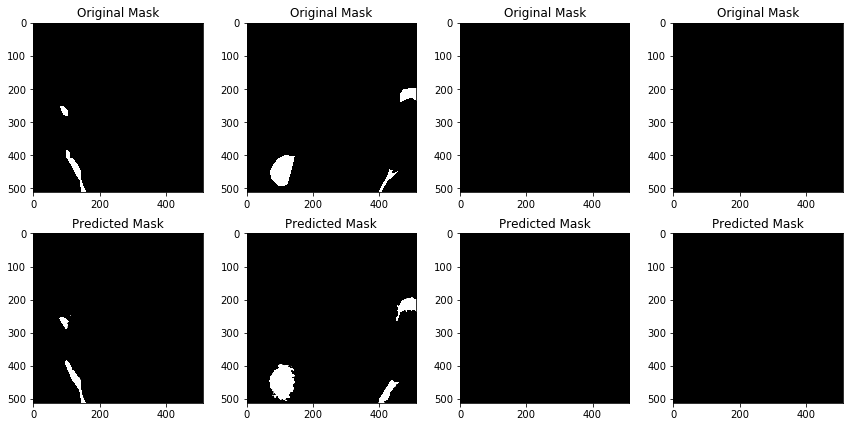

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to load images and convert data type if needed
def load_binary_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Failed to load image at {image_path}")
        return None
    return image

# Folder path
folder_path = 'Predictions/test_4k_Attention_res_net_2k_lake_2k_no_lake'

# Load and plot the random images and their predictions
def plot_images(folder_path, prefix, num_images=4):
    original_images = []
    predicted_images = []
    
    # List all the original mask images in the folder
    all_images = [img for img in os.listdir(folder_path) if img.startswith("{}_mask_img_".format(prefix))]
    
    # Randomly select num_images filenames
    random_selected_images = random.sample(all_images, num_images)
    
    for image_file_name in random_selected_images:
        prediction_file_name = image_file_name.replace("{}_mask_img_".format(prefix), "Predicted_{}_img_".format(prefix.lower()))
        
        original_image = load_binary_image(os.path.join(folder_path, image_file_name))
        predicted_image = load_binary_image(os.path.join(folder_path, prediction_file_name))
        
        if original_image is not None and predicted_image is not None:
            original_images.append(original_image)
            predicted_images.append(predicted_image)

    plt.figure(figsize=(12, 6))
    for i in range(len(original_images)):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i], cmap='gray')
        plt.title('Original Mask')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(predicted_images[i], cmap='gray')
        plt.title('Predicted Mask')

    plt.tight_layout()
    plt.show()

# Call the function to plot the images
plot_images(folder_path, "Test", num_images=4)


***Attention: If you download the saved model(best_model_lake_512_512_2k_lake_2k_none_res_attention_fold_1.h5) and test_tiles_no_overlap from Google Drive, You can skip the above step until here.***



**Part 3. Make a prediction on the final test set (12 test images). Define data generator.**

The below contains a data generator for reading the tiled test images to make a prediction.

(There are 4 images containing 12 regions. All the test regions are divided into tiles of 512,512 to be used for prediction with the model trained on 512,512 image
 dimensions).
 The patch of the tiled test files must be set in the below code, like:

 *test_image_directory='test_tiles_no_overlap'*


In [272]:
# First: set the path of tiled test image
test_image_directory='test_tiles_no_overlap'
test_image_paths = [os.path.join(test_image_directory, filename) for filename in os.listdir(test_image_directory) if filename.endswith('.tif')]
batch_size = 12

In [45]:
# Second, read test images with data generator
import os
import cv2
import numpy as np
import tensorflow as tf
from skimage.transform import resize

class TestDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_paths, batch_size):
        self.img_paths = img_paths
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.img_paths))

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start:end]
        batch_img_paths = [self.img_paths[i] for i in batch_indexes]

        batch_images = [self._load_image(img_path) for img_path in batch_img_paths]

        # Filter out None values (invalid images)
        batch_images = [img for img in batch_images if img is not None]
        batch_img_paths = [img_path for img_path, img in zip(batch_img_paths, batch_images)]

        return np.array(batch_images), batch_img_paths

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def _load_image(self, img_path):
        try:
            image = cv2.imread(img_path)
            if image is None:
                raise Exception(f"Error loading image: {img_path}")

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Resize the image to the expected shape ( 512, 512,3)
            image = cv2.resize(image, (512, 512))

            # Normalize the pixel values to the range [0, 1]
            image = image / 255.0

            return image
        except Exception as e:
            print(f"Error loading image: {img_path} - {str(e)}")
            return None

# Define TestDataGenerator class above

# Initialize the TestDataGenerator with test image paths
test_data_generator = TestDataGenerator(img_paths=test_image_paths, batch_size=batch_size)


**Predict the final test set (tiled 12 large test images)**

1. The model, which is trained with the train data, must be added to the below code. Like the below line:

model.load_weights("best_model_lake_512_512_2k_lake_2k_none_res_attention_fold_1.h5")

2. The tiled test images must be added in the below cell:

test_image_directory = 'test_tiles_no_overlap'

Set Paths for saving predicted images and original test images in the below cell

output_folder_predicted = "Final_Predictions/predicted_test_4k_Attention_res_net_2k_lake_2k_no_lake_no_overlap"

output_folder_original = "Final_Predictions/original_test_4k_Attention_res_net_2k_lake_2k_no_lake_no_overlap"


In [298]:
import os

# Define the folder path
output_folder_predicted = "Final_Predictions/predicted_test_4k_Attention_res_net_2k_lake_2k_no_lake_no_overlap"

# Check if the folder already exists, if not, create it
if not os.path.exists(output_folder_predicted):
    os.makedirs(output_folder_predicted)

# Define the folder path
output_folder_original = "Final_Predictions/original_test_4k_Attention_res_net_2k_lake_2k_no_lake_no_overlap"

# Check if the folder already exists, if not, create it
if not os.path.exists(output_folder_original):
    os.makedirs(output_folder_original )    

In [ ]:
# 3. Make prediction on final test set (tile with the 0- padding- with no overlap)

import os
import cv2
import numpy as np
import shutil
import tensorflow as tf

input_shape = (512, 512, 3)
model = Attention_ResUNet(input_shape) 

# Load the model weights from the .h5 file
model.load_weights("best_model_lake_512_512_2k_lake_2k_none_res_attention_fold_1.h5")

# Compile the model and specify the custom metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=dice_loss,
    metrics=[binary_iou, dice_coef, F1_score] 
)

# Initialize the TestDataGenerator with test image paths
test_image_directory = 'test_tiles_no_overlap'

# List all image files in the directory
test_image_paths = [os.path.join(test_image_directory, filename) for filename in os.listdir(test_image_directory) if filename.endswith('.tif')]
batch_size = 12  # Adjust as needed
test_data_generator = TestDataGenerator(test_image_paths, batch_size)

# Initialize lists to store predictions and original image paths
all_predictions = []
all_original_paths = []

# 5. Loop through the DataGenerator, make predictions, and save the results.
for batch_images, batch_img_paths in test_data_generator:
    if batch_images is not None:
        # Filter out invalid images (None elements)
        valid_indices = [i for i, img in enumerate(batch_images) if img is not None]
        valid_batch_images = [batch_images[i] for i in valid_indices]
        valid_batch_img_paths = [batch_img_paths[i] for i in valid_indices]

        if valid_batch_images:
            # Make predictions for valid images
            predictions = model.predict(np.array(valid_batch_images))  # Ensure numpy array

            # Save predicted images with their original names
            for i, img_path in enumerate(valid_batch_img_paths):
                img_name = os.path.basename(img_path)
                img_name_without_extension, _ = os.path.splitext(img_name)
                output_path = os.path.join(output_folder_predicted, img_name_without_extension + ".tif")

                # Save the predicted image (ensure it's in the correct format)
                # Save the predicted image as a single-channel grayscale image
                cv2.imwrite(output_path, predictions[i].astype(np.uint8) * 255, [cv2.IMWRITE_PNG_COMPRESSION, 0])


                # Copy the original test image to the "original" folder
                original_output_path = os.path.join(output_folder_original, img_name)
                shutil.copy2(img_path, original_output_path)

                # Append predictions and original image paths to lists
                all_predictions.append(predictions[i])
                all_original_paths.append(original_output_path)
        else:
            print("No valid images in the batch. Skipping...")
    else:
        print("Error loading batch of images. Skipping...")

# Convert the lists to NumPy arrays for further processing if needed
all_predictions = np.array(all_predictions)
all_original_paths = np.array(all_original_paths)

# Now we have the predictions and original image paths for further analysis


**End part**

**Part 4. Stitch the tiled test images and the predicted images with the dimensions of 512, 512 to have 12 regions' predictions with their original sizes.**

We must set the path to the JSON folder, which contains each image's information of added 0 padding positions in each image.

We must set the paths in the code below to stitch predicted images together:

input_folder = "test_tiles_no_overlap"

output_folder = "stitched_tiled_test_images"

metadata_folder = "json_test_tiles_no_overlap"


In [3]:
# It works correctly, stitching the tiled test images to rebuild the 12 images
import os
import numpy as np
import rasterio
from rasterio.windows import Window
import json

def stitch_tiles(input_folder, output_folder, metadata_folder):
    for root, _, files in os.walk(metadata_folder):
        for metadata_file in files:
            if metadata_file.endswith("_metadata.json"):
                metadata_path = os.path.join(root, metadata_file)
                with open(metadata_path, 'r') as json_file:
                    metadata = json.load(json_file)

                # Determine the dimensions of the stitched image based on the metadata
                max_x = max(
                    tile_info["x_offset"] + tile_info["width"]  # Include padding in width
                    for tile_info in metadata
                )
                max_y = max(
                    tile_info["y_offset"] + tile_info["height"]  # Include padding in height
                    for tile_info in metadata
                )

                min_x = min(tile_info["x_offset"] for tile_info in metadata)
                min_y = min(tile_info["y_offset"] for tile_info in metadata)

                stitched_width = max_x - min_x
                stitched_height = max_y - min_y

                stitched_image = np.zeros((stitched_height, stitched_width), dtype=np.uint8)

                for tile_info in metadata:
                    tile_path = os.path.join(input_folder, tile_info["tile_name"])

                    x_start = tile_info["x_offset"]
                    y_start = tile_info["y_offset"]
                    tile_width = tile_info["width"]
                    tile_height = tile_info["height"]
                    padding_x, padding_y = tile_info["padding"]

                    # Calculate the coordinates for adding the tile to the stitched image
                    x_stitched_start = x_start - min_x
                    y_stitched_start = y_start - min_y
                    x_stitched_end = x_stitched_start + tile_width
                    y_stitched_end = y_stitched_start + tile_height

                    # Read the tile data
                    with rasterio.open(tile_path) as src:
                        tile_data = src.read(1)

                    # Crop the tile data to exclude padding
                    tile_data = tile_data[padding_y:padding_y+tile_height, padding_x:padding_x+tile_width]

                    # Calculate the corresponding coordinates in the stitched image
                    x_stitched_coords = slice(x_stitched_start, x_stitched_end)
                    y_stitched_coords = slice(y_stitched_start, y_stitched_end)

                    # Add the tile data to the stitched image
                    stitched_image[y_stitched_coords, x_stitched_coords] = tile_data

                # Save the stitched image
                output_image_path = os.path.join(output_folder, metadata_file.replace("_metadata.json", ".tif"))
                with rasterio.open(output_image_path, 'w', driver='GTiff', width=stitched_width, height=stitched_height, count=1, dtype=np.uint8) as dst:
                    dst.write(stitched_image, 1)

# Define input and output directories
input_folder = "test_tiles_no_overlap"
output_folder = "stitched_tiled_test_images_submission_5"
metadata_folder = "json_test_tiles_no_overlap"

# Ensure output directory exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Stitch the predicted tiles
stitch_tiles(input_folder, output_folder, metadata_folder)


/home/in18657@ad.umbc.edu/.local/lib/python3.8/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


**Stitching the tiled predicted images to rebuild the 12 predicted images**

input_folder = "Final_Predictions/predicted_test_4k_Attention_res_net_2k_lake_2k_no_lake_no_overlap"

output_folder = "stitched_test_prediction"

metadata_folder = "json_test_tiles_no_overlap"

In [4]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window
import json

def stitch_binary_prediction_tiles(input_folder, output_folder, metadata_folder):
    for root, _, files in os.walk(metadata_folder):
        for metadata_file in files:
            if metadata_file.endswith("_metadata.json"):
                metadata_path = os.path.join(root, metadata_file)
                with open(metadata_path, 'r') as json_file:
                    metadata = json.load(json_file)

                # Determine the dimensions of the stitched image based on the metadata
                max_x = max(
                    tile_info["x_offset"] + tile_info["width"]  # Include padding in width
                    for tile_info in metadata
                )
                max_y = max(
                    tile_info["y_offset"] + tile_info["height"]  # Include padding in height
                    for tile_info in metadata
                )

                min_x = min(tile_info["x_offset"] for tile_info in metadata)
                min_y = min(tile_info["y_offset"] for tile_info in metadata)

                stitched_width = max_x - min_x
                stitched_height = max_y - min_y

                stitched_image = np.zeros((stitched_height, stitched_width), dtype=np.uint8)

                for tile_info in metadata:
                    tile_path = os.path.join(input_folder, tile_info["tile_name"])

                    x_start = tile_info["x_offset"]
                    y_start = tile_info["y_offset"]
                    tile_width = tile_info["width"]
                    tile_height = tile_info["height"]
                    padding_x, padding_y = tile_info["padding"]

                    # Calculate the coordinates for adding the tile to the stitched image
                    x_stitched_start = x_start - min_x
                    y_stitched_start = y_start - min_y
                    x_stitched_end = x_stitched_start + tile_width
                    y_stitched_end = y_stitched_start + tile_height

                    # Read the tile data
                    with rasterio.open(tile_path) as src:
                        tile_data = src.read(1)

                    # Crop the tile data to exclude padding
                    tile_data = tile_data[padding_y:padding_y+tile_height, padding_x:padding_x+tile_width]

                    # Calculate the corresponding coordinates in the stitched image
                    x_stitched_coords = slice(x_stitched_start, x_stitched_end)
                    y_stitched_coords = slice(y_stitched_start, y_stitched_end)

                    # Add the tile data to the stitched image
                    stitched_image[y_stitched_coords, x_stitched_coords] = tile_data

                # Save the stitched image as a single-band (one channel) binary image
                output_image_path = os.path.join(output_folder, metadata_file.replace("_metadata.json", ".tif"))
                with rasterio.open(output_image_path, 'w', driver='GTiff', width=stitched_width, height=stitched_height, count=1, dtype=np.uint8) as dst:
                    dst.write(stitched_image, 1)

# Define input and output directories
input_folder = "Final_Predictions/predicted_test_4k_Attention_res_net_2k_lake_2k_no_lake_no_overlap"
output_folder = "stitched_test_prediction_submission_5"
metadata_folder = "json_test_tiles_no_overlap"

# Ensure output directory exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Stitch the binary prediction tiles
stitch_binary_prediction_tiles(input_folder, output_folder, metadata_folder)


/home/in18657@ad.umbc.edu/.local/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


**End Part 4**

***Below cells are sanity check, there is no need to run them***

**Start of sanity checks**

Check the dimensions of 12 original images, stitched tiles of 12 test images, and stitched predicted images with the original large test images.


In [273]:
input_directory = "test"  # Adjust the path accordingly to the 12 original test images

import os
import rasterio

# Lists to store information
image_sizes = []
image_names = []

# Iterate through all files in the directory
for filename in os.listdir(input_directory):
    if filename.endswith((".tif", ".tiff")):  # Checking for both .tif and .tiff extensions
        full_path = os.path.join(input_directory, filename)
        with rasterio.open(full_path) as src:
            width, height = src.width, src.height
            image_sizes.append((width, height))
            image_names.append(filename)

# Print the size and count details
for name, size in zip(image_names, image_sizes):
    print(f"Image: {name}, Width: {size[0]}, Height: {size[1]}")

print(f"\nTotal .tif (or .tiff) images in the folder: {len(image_names)}")

Image: Greenland26X_22W_Sentinel2_2019-06-03_05_region_3.tif, Width: 14414, Height: 9723
Image: Greenland26X_22W_Sentinel2_2019-08-25_29_region_6.tif, Width: 28235, Height: 22641
Image: Greenland26X_22W_Sentinel2_2019-06-03_05_region_1.tif, Width: 13078, Height: 8733
Image: Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif, Width: 31216, Height: 24194
Image: Greenland26X_22W_Sentinel2_2019-06-19_20_region_6.tif, Width: 28235, Height: 22641
Image: Greenland26X_22W_Sentinel2_2019-08-25_29_region_2.tif, Width: 14957, Height: 8710
Image: Greenland26X_22W_Sentinel2_2019-06-19_20_region_4.tif, Width: 13524, Height: 10358
Image: Greenland26X_22W_Sentinel2_2019-07-31_25_region_1.tif, Width: 13078, Height: 8733
Image: Greenland26X_22W_Sentinel2_2019-06-19_20_region_2.tif, Width: 14957, Height: 8710
Image: Greenland26X_22W_Sentinel2_2019-08-25_29_region_4.tif, Width: 13524, Height: 10358
Image: Greenland26X_22W_Sentinel2_2019-06-03_05_region_5.tif, Width: 31216, Height: 24194
Image: Greenlan

In [5]:
input_directory = "stitched_tiled_test_images_submission_5"  # Adjust the path accordingly to the stitched test images

# Lists to store information
image_sizes = []
image_names = []

# Iterate through all files in the directory
for filename in os.listdir(input_directory):
    if filename.endswith((".tif", ".tiff")):  # Checking for both .tif and .tiff extensions
        full_path = os.path.join(input_directory, filename)
        with rasterio.open(full_path) as src:
            width, height = src.width, src.height
            image_sizes.append((width, height))
            image_names.append(filename)

# Print the size and count details
for name, size in zip(image_names, image_sizes):
    print(f"Image: {name}, Width: {size[0]}, Height: {size[1]}")

print(f"\nTotal .tif (or .tiff) images in the folder: {len(image_names)}")

Image: Greenland26X_22W_Sentinel2_2019-06-03_05_region_3.tif, Width: 14414, Height: 9723
Image: Greenland26X_22W_Sentinel2_2019-08-25_29_region_6.tif, Width: 28235, Height: 22641
Image: Greenland26X_22W_Sentinel2_2019-06-03_05_region_1.tif, Width: 13078, Height: 8733
Image: Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif, Width: 31216, Height: 24194
Image: Greenland26X_22W_Sentinel2_2019-06-19_20_region_6.tif, Width: 28235, Height: 22641
Image: Greenland26X_22W_Sentinel2_2019-08-25_29_region_2.tif, Width: 14957, Height: 8710
Image: Greenland26X_22W_Sentinel2_2019-06-19_20_region_4.tif, Width: 13524, Height: 10358
Image: Greenland26X_22W_Sentinel2_2019-07-31_25_region_1.tif, Width: 13078, Height: 8733
Image: Greenland26X_22W_Sentinel2_2019-06-19_20_region_2.tif, Width: 14957, Height: 8710
Image: Greenland26X_22W_Sentinel2_2019-08-25_29_region_4.tif, Width: 13524, Height: 10358
Image: Greenland26X_22W_Sentinel2_2019-06-03_05_region_5.tif, Width: 31216, Height: 24194
Image: Greenlan

In [6]:
import os
import rasterio

input_directory = "stitched_test_prediction_submission_5"  # Adjust the path accordingly to the stitched predicted images

# Lists to store information
image_sizes = []
image_names = []

# Iterate through all files in the directory
for filename in os.listdir(input_directory):
    if filename.endswith((".tif", ".tiff")):  # Checking for both .tif and .tiff extensions
        full_path = os.path.join(input_directory, filename)
        with rasterio.open(full_path) as src:
            width, height = src.width, src.height
            image_sizes.append((width, height))
            image_names.append(filename)

# Print the size and count details
for name, size in zip(image_names, image_sizes):
    print(f"Image: {name}, Width: {size[0]}, Height: {size[1]}")

print(f"\nTotal .tif (or .tiff) images in the folder: {len(image_names)}")

Image: Greenland26X_22W_Sentinel2_2019-06-03_05_region_3.tif, Width: 14414, Height: 9723
Image: Greenland26X_22W_Sentinel2_2019-08-25_29_region_6.tif, Width: 28235, Height: 22641
Image: Greenland26X_22W_Sentinel2_2019-06-03_05_region_1.tif, Width: 13078, Height: 8733
Image: Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif, Width: 31216, Height: 24194
Image: Greenland26X_22W_Sentinel2_2019-06-19_20_region_6.tif, Width: 28235, Height: 22641
Image: Greenland26X_22W_Sentinel2_2019-08-25_29_region_2.tif, Width: 14957, Height: 8710
Image: Greenland26X_22W_Sentinel2_2019-06-19_20_region_4.tif, Width: 13524, Height: 10358
Image: Greenland26X_22W_Sentinel2_2019-07-31_25_region_1.tif, Width: 13078, Height: 8733
Image: Greenland26X_22W_Sentinel2_2019-06-19_20_region_2.tif, Width: 14957, Height: 8710
Image: Greenland26X_22W_Sentinel2_2019-08-25_29_region_4.tif, Width: 13524, Height: 10358
Image: Greenland26X_22W_Sentinel2_2019-06-03_05_region_5.tif, Width: 31216, Height: 24194
Image: Greenlan

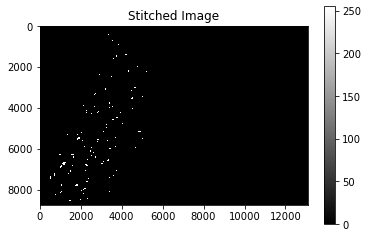

In [7]:
import matplotlib.pyplot as plt
import rasterio

def plot_stitched_image(stitched_image_path):
    with rasterio.open(stitched_image_path) as src:
        # Read the stitched image data
        image = src.read(1)  # Assuming a single band image, adjust if multi-band

        # Plot the image with the 'gray' colormap
        plt.imshow(image, cmap='gray')
        plt.colorbar()
        plt.title("Stitched Image")
        plt.show()
stitched_image_path = "stitched_test_prediction_submission_5/Greenland26X_22W_Sentinel2_2019-06-03_05_region_1.tif"
plot_stitched_image(stitched_image_path)


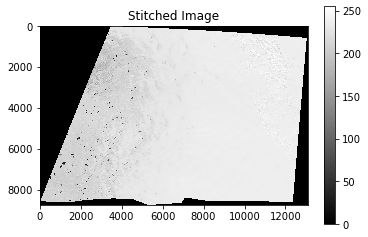

In [8]:
import matplotlib.pyplot as plt
import rasterio

def plot_stitched_image(stitched_image_path):
    with rasterio.open(stitched_image_path) as src:
        # Read the stitched image data
        image = src.read(1)
        plt.imshow(image, cmap='gray')
        plt.colorbar()
        plt.title("Stitched Image")
        plt.show()
stitched_image_path = "stitched_tiled_test_images_submission_5/Greenland26X_22W_Sentinel2_2019-06-03_05_region_1.tif"
plot_stitched_image(stitched_image_path)

In [279]:
import rasterio

with rasterio.open(stitched_image_path) as src:
    image = src.read(1)  # Assuming a single band image, adjust if multi-band
    print("Data Type:", image.dtype)
    print("Min Value:", image.min())
    print("Max Value:", image.max())


Data Type: uint8
Min Value: 0
Max Value: 255


**End of the sanity check**

****Part 5. Align 12 predicted images' coordinates with the original test images.****

The below patch must be set:

Define the paths to the folders containing the original test images and predicted images

original_images_folder = "test/"

predicted_images_folder = "stitched_test_prediction/"

output_folder = "projected_predicted_images/"

In [9]:

# Define the paths to the folders containing the original test images and predicted images
original_images_folder = "test/"
predicted_images_folder = "stitched_test_prediction_submission_5/"
output_folder = "projected_predicted_images_submission_5/"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
    
    
    
# Get a list of all files in the original images folder
original_image_files = os.listdir(original_images_folder)

# Iterate through each original image
for original_image_file in original_image_files:
    # Construct the full paths to the original and predicted images
    original_image_path = os.path.join(original_images_folder, original_image_file)
    predicted_image_path = os.path.join(predicted_images_folder, original_image_file)

    # Check if the predicted image exists
    if os.path.exists(predicted_image_path):
        # Open the original test image to get its CRS and affine transformation
        with rasterio.open(original_image_path) as test_src:
            crs = test_src.crs
            transform = test_src.transform

        # Open the predicted image
        with rasterio.open(predicted_image_path) as pred_src:
            # Read the predicted image as a numpy array
            predicted_image = pred_src.read(1)  # Read the first (and only) channel

            # Create a new image with the same CRS and affine transformation as the original test image
            new_image_profile = {
                'driver': 'GTiff',
                'dtype': predicted_image.dtype,
                'count': 1,  # Assuming the predicted image has a single channel
                'width': pred_src.width,
                'height': pred_src.height,
                'crs': crs,
                'transform': transform,
            }

            # Define the path to save the new image
            new_image_file = f"{original_image_file}"
            new_image_path = os.path.join(output_folder, new_image_file)

            # Write the predicted image to the new image file with the updated profile
            with rasterio.open(new_image_path, 'w', **new_image_profile) as new_image:
                new_image.write(predicted_image, 1)  # Write the single channel

            print(f"New image saved: {new_image_path}")
    else:
        print(f"Predicted image not found for {original_image_file}")

New image saved: projected_predicted_images_submission_5/Greenland26X_22W_Sentinel2_2019-06-03_05_region_3.tif
New image saved: projected_predicted_images_submission_5/Greenland26X_22W_Sentinel2_2019-08-25_29_region_6.tif
New image saved: projected_predicted_images_submission_5/Greenland26X_22W_Sentinel2_2019-06-03_05_region_1.tif
New image saved: projected_predicted_images_submission_5/Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif
New image saved: projected_predicted_images_submission_5/Greenland26X_22W_Sentinel2_2019-06-19_20_region_6.tif
New image saved: projected_predicted_images_submission_5/Greenland26X_22W_Sentinel2_2019-08-25_29_region_2.tif
New image saved: projected_predicted_images_submission_5/Greenland26X_22W_Sentinel2_2019-06-19_20_region_4.tif
New image saved: projected_predicted_images_submission_5/Greenland26X_22W_Sentinel2_2019-07-31_25_region_1.tif
New image saved: projected_predicted_images_submission_5/Greenland26X_22W_Sentinel2_2019-06-19_20_region_2.tif
N

In [12]:
import os
import rasterio
from rasterio.warp import reproject, Resampling

image_folder_path = "projected_predicted_images_submission_5"  # Image folder path
mask_folder_path = "test"  # Mask folder path


def reproject_to_match(predicted_image_path, original_image_path, output_path):
    with rasterio.open(predicted_image_path) as predicted:
        predicted_data = predicted.read(1)
        
        with rasterio.open(original_image_path) as original:
            # Define the parameters for the reprojection
            transform, width, height = rasterio.warp.calculate_default_transform(
                predicted.crs, original.crs, predicted.width, predicted.height, *predicted.bounds)
            kwargs = original.meta.copy()
            kwargs.update({
                'crs': original.crs,
                'transform': transform,
                'width': width,
                'height': height
            })
            
            # Create the reprojected dataset
            with rasterio.open(output_path, 'w', **kwargs) as dest:
                reproject(
                    source=rasterio.band(predicted, 1),
                    destination=rasterio.band(dest, 1),
                    src_transform=predicted.transform,
                    src_crs=predicted.crs,
                    dst_transform=transform,
                    dst_crs=original.crs,
                    resampling=Resampling.nearest)


# Loop over all the predicted images in the folder and apply reprojection
for predicted_image_name in os.listdir(image_folder_path):
    if predicted_image_name.endswith('.tif'):
        predicted_image_path = os.path.join(image_folder_path, predicted_image_name)
        original_image_path = os.path.join(mask_folder_path, predicted_image_name)
        
        # Ensure the original image also exists
        if os.path.exists(original_image_path):
            output_image_path = os.path.join(image_folder_path, f"reprojected_{predicted_image_name}")
            reproject_to_match(predicted_image_path, original_image_path, output_image_path)
        else:
            print(f"No matching original image found for {predicted_image_name}. Skipping.")

In [13]:
# correct names of images 

def rename_images_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        # Check if '.tif_' exists in filename
        if '.tif' in filename:
            # Create a new filename by replacing '.tif_'
            new_filename = filename.replace('reprojected_G', 'G')
            # Get the full paths
            original_path = os.path.join(folder_path, filename)
            new_path = os.path.join(folder_path, new_filename)
            # Rename the file
            os.rename(original_path, new_path)
            print(f"Renamed: {filename} -> {new_filename}")

# Example usage:
folder_path = "projected_predicted_images_submission_5"
rename_images_in_folder(folder_path)

Renamed: reprojected_Greenland26X_22W_Sentinel2_2019-06-19_20_region_4.tif -> Greenland26X_22W_Sentinel2_2019-06-19_20_region_4.tif
Renamed: reprojected_Greenland26X_22W_Sentinel2_2019-07-31_25_region_1.tif -> Greenland26X_22W_Sentinel2_2019-07-31_25_region_1.tif
Renamed: reprojected_Greenland26X_22W_Sentinel2_2019-08-25_29_region_4.tif -> Greenland26X_22W_Sentinel2_2019-08-25_29_region_4.tif
Renamed: reprojected_Greenland26X_22W_Sentinel2_2019-06-19_20_region_2.tif -> Greenland26X_22W_Sentinel2_2019-06-19_20_region_2.tif
Renamed: reprojected_Greenland26X_22W_Sentinel2_2019-06-19_20_region_6.tif -> Greenland26X_22W_Sentinel2_2019-06-19_20_region_6.tif
Renamed: reprojected_Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif -> Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif
Renamed: reprojected_Greenland26X_22W_Sentinel2_2019-07-31_25_region_3.tif -> Greenland26X_22W_Sentinel2_2019-07-31_25_region_3.tif
Renamed: reprojected_Greenland26X_22W_Sentinel2_2019-06-03_05_region_3.tif -

**End part 5**

***Sanity check: there is no need to run 6 below cells.***

**Start of the sanity checks**

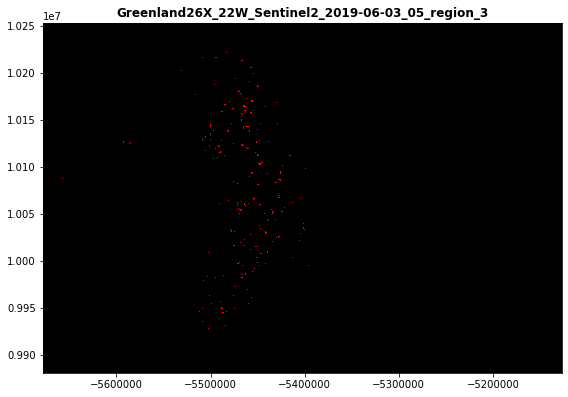

In [14]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from shapely.geometry import box

# Specify the path to the GeoTIFF file you want to plot
image_path =  "projected_predicted_images_submission_5/Greenland26X_22W_Sentinel2_2019-06-03_05_region_3.tif" 

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(8, 8))

# Open the GeoTIFF file
with rasterio.open(image_path) as src:
    # Get the shape of the image
    shape = (src.height, src.width)

    # Create a Polygon geometry representing the extent of the image
    geom = gpd.GeoSeries([box(*src.bounds)], crs=src.crs)

    # Create a GeoDataFrame with the geometry
    tif_gdf = gpd.GeoDataFrame(geometry=geom)

    # Plot the raster content within the bounding box
    show(src, ax=ax, title="Greenland26X_22W_Sentinel2_2019-06-03_05_region_3", cmap='viridis')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

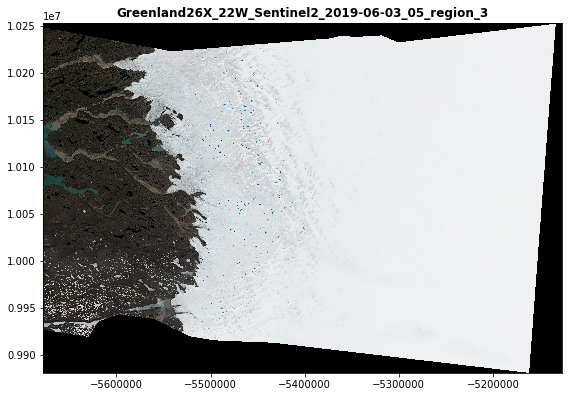

In [16]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from shapely.geometry import box

# Specify the path to the GeoTIFF file you want to plot
image_path =  "test/Greenland26X_22W_Sentinel2_2019-06-03_05_region_3.tif"  

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(8, 8))

# Open the GeoTIFF file
with rasterio.open(image_path) as src:
    # Get the shape of the image
    shape = (src.height, src.width)

    # Create a Polygon geometry representing the extent of the image
    geom = gpd.GeoSeries([box(*src.bounds)], crs=src.crs)

    # Create a GeoDataFrame with the geometry
    tif_gdf = gpd.GeoDataFrame(geometry=geom)

    # Plot the raster content within the bounding box
    show(src, ax=ax, title="Greenland26X_22W_Sentinel2_2019-06-03_05_region_3", cmap='viridis')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


**Sanity checks to plot randomly a part of a predicted test image and its corresponding part in the original test set.**

The paths to the original test folder and the projected predicted images must be set in the below cell.

resampled_image_path = "projected_predicted_images/Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif"

test_image_path = "test/Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif"

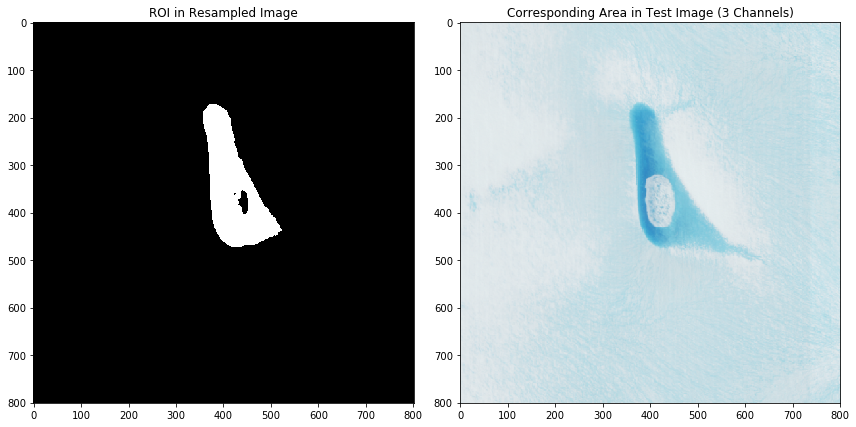

In [17]:
import rasterio
import numpy as np
import random
import matplotlib.pyplot as plt

# Define the paths to the resampled image and test image
resampled_image_path = "projected_predicted_images_submission_5/Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif"
test_image_path = "test/Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif"

# Seed the random number generator to ensure different results each time
random.seed()

# Open the resampled image
with rasterio.open(resampled_image_path) as resampled_src:
    # Read the resampled image as a numpy array
    resampled_image = resampled_src.read(1)

    # Find the coordinates of white pixels (pixel value == 255)
    white_pixel_coords = np.argwhere(resampled_image == 255)

    if white_pixel_coords.size == 0:
        print("No white pixels found in the resampled image.")
    else:
        # Randomly select one set of coordinates from the white pixels
        random_index = random.randint(0, white_pixel_coords.shape[0] - 1)
        y, x = white_pixel_coords[random_index]

        # Define the size of the smaller area
        area_size = 800

        # Calculate the coordinates for the smaller area
        min_y = max(y - area_size // 2, 0)
        max_y = min(y + area_size // 2, resampled_image.shape[0])
        min_x = max(x - area_size // 2, 0)
        max_x = min(x + area_size // 2, resampled_image.shape[1])

        # Extract the smaller area from the resampled image
        roi_resampled = resampled_image[min_y:max_y+1, min_x:max_x+1]

        # Open the test image with three channels (assuming it's a color image)
        with rasterio.open(test_image_path) as test_src:
            # Read the test image as a numpy array with three channels
            test_image = test_src.read([1, 2, 3])

            # Extract the corresponding area from the test image using the same coordinates
            roi_test = test_image[:, min_y:max_y+1, min_x:max_x+1]

        # Plot the ROI in both images for comparison
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(roi_resampled, cmap='gray')
        plt.title("ROI in Resampled Image")

        plt.subplot(1, 2, 2)
        plt.imshow(np.transpose(roi_test, (1, 2, 0)))  # Transpose the channels for correct display
        plt.title("Corresponding Area in Test Image (3 Channels)")

        plt.tight_layout()
        plt.show()


**Sanity check: Display a part of the predicted image and its mask using their correct spatial coordinates, even when only displaying a small ROI from the larger images.**

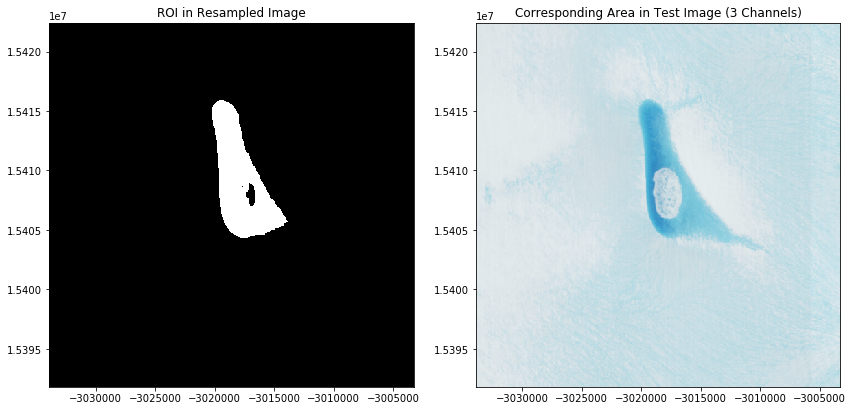

In [18]:
import rasterio.plot

# After extracting the ROI from the resampled image...
transform_resampled = resampled_src.transform
transform_test = test_src.transform

# Adjust the affine transform to account for the ROI
transform_resampled_roi = transform_resampled * rasterio.Affine.translation(min_x, min_y)
transform_test_roi = transform_test * rasterio.Affine.translation(min_x, min_y)

# Calculate extents for the images (left, right, bottom, top)
extent_resampled = rasterio.plot.plotting_extent(roi_resampled, transform_resampled_roi)
extent_test = rasterio.plot.plotting_extent(roi_test[0, :, :], transform_test_roi)  # Assuming all bands have the same extent

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(roi_resampled, cmap='gray', extent=extent_resampled)
plt.title("ROI in Resampled Image")

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(roi_test, (1, 2, 0)), extent=extent_test)
plt.title("Corresponding Area in Test Image (3 Channels)")

plt.tight_layout()
plt.show()


**This will overlay the resampled image on top of the test image. By adjusting the alpha parameter, we can change the transparency of the resampled image to visually inspect alignment more or less clearly.**

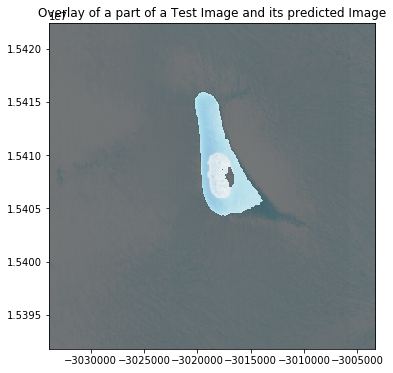

In [19]:
plt.figure(figsize=(12, 6))

# Display the test image as the base image
plt.imshow(np.transpose(roi_test, (1, 2, 0)), extent=extent_test)

# Overlay the resampled image with 10% transparency
plt.imshow(roi_resampled, cmap='gray', alpha=0.5, extent=extent_resampled)

plt.title("Overlay of a part of a Test Image and its predicted Image")
plt.show()



**End of the sanity checks**

**Part 6. Providing lake_polygons_test.gpkg**

A GeoPackage with your "answers" to the "test" regions should

be named “lake_polygons_test.gpkg”

have an identical column format to the “lake_polygons_training.gpkg” file, with each lake polygon specifying the image from which it was derived specified in the “image” column

be in the EPSG:3857 (“WGS 84 / Pseudo-Mercator”) coordinate reference system, the same as the input rasters and all provided GeoPackage files.


Below code create lake_polygons_test.gpkg.

The below path must be set:

test_prediction_dir = "projected_predicted_images"

Making  "lake_polygons_test.gpkg" by the format of traing.gpkg. The training.gpkg contains 4 images contains 6 regions. Below cell create lake_polygons_test.gpkg with the stracture of traing.gpkg.

In [16]:
import os
import geopandas as gpd
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape, Point
import re

# Function to validate lake shapes
def is_valid_lake(polygon):
    # Check if it's a simple polygon without any holes
    if not polygon.is_simple or len(polygon.interiors) > 0:
        return False

    # Compute the minimum bounding rectangle
    min_rect = polygon.minimum_rotated_rectangle
    # Extract the coordinates of the rectangle
    coords = list(min_rect.exterior.coords)
    
    # Compute the two sides of the rectangle
    side1 = Point(coords[0]).distance(Point(coords[1]))
    side2 = Point(coords[1]).distance(Point(coords[2]))
    
    # Get length and width of the rectangle
    length = max(side1, side2)
    width = min(side1, side2)
    
    # Check the length-to-width ratio
    if length / width > 10:
        return False
    return True

# Directory containing binary test prediction images
test_prediction_dir = "projected_predicted_images_submission_5"

# Create an empty list to store test polygons
test_polygons = []

# Regular expression pattern to extract the file name and region number
pattern = r"(.*)_region_(\d+)\.tif"

# Iterate through each binary test prediction image
for filename in os.listdir(test_prediction_dir):
    if filename.endswith(".tif"):
        match = re.search(pattern, filename)
        if match:
            image_name = match.group(1)  # Extract the file name
            region_num = int(match.group(2))  # Extract the region number
        else:
            raise ValueError(f"Invalid filename format: {filename}")

        test_image_path = os.path.join(test_prediction_dir, filename)

        with rasterio.open(test_image_path) as src:
            if src.crs != "EPSG:3857":
                raise ValueError(f"CRS mismatch for {filename}. Expected EPSG:3857, but found {src.crs}")

            image_data = src.read(1)
            mask = (image_data == 255).astype('uint8')  # Assuming lakes are represented by 255

            for geometry, value in shapes(mask, transform=src.transform, mask=mask):
                if value == 1:  # Assuming the shapes function returns 1 for lakes
                    polygon_shape = shape(geometry)
                    if polygon_shape.area > 100000 and is_valid_lake(polygon_shape):
                        test_polygons.append({
                            "image": image_name,
                            "region_num": region_num,
                            "geometry": polygon_shape
                        })

print(f"Total number of test polygons: {len(test_polygons)}")

# Create a GeoDataFrame from the test polygons list
test_gdf = gpd.GeoDataFrame(test_polygons, geometry='geometry')

# Set the test GeoDataFrame's coordinate reference system (CRS)
test_gdf.crs = "EPSG:3857"

# Save the test GeoDataFrame to a GeoPackage file
output_test_gpkg = "lake_polygons_test.gpkg"
test_gdf.to_file(output_test_gpkg, driver="GPKG")

print(f"GeoPackage file '{output_test_gpkg}' for the test set created successfully.")

Total number of test polygons: 3200
GeoPackage file 'lake_polygons_test.gpkg' for the test set created successfully.


***End part 6***

***There is no need to run below cells, these are just sanity check***

Below are just sanity check for becoming sure whether "lake_polygons_test.gpkg" and lake_polygons_training.gpkg" are match.

In [17]:
import os
import geopandas as gpd
import shutil

# Path to the test GeoPackage file
test_gpkg_path = "lake_polygons_test.gpkg"

# Directory to save the extracted images
output_folder = "extracted_test_images"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Read the test GeoDataFrame containing all test polygons
test_gdf = gpd.read_file(test_gpkg_path)

# Get unique image names from the test GeoDataFrame
unique_images = test_gdf["image"].unique()
print(unique_images)

# Iterate through each unique image and save it to the output folder
for image_name in unique_images:
    # Filter the GeoDataFrame for the current image
    image_gdf = test_gdf[test_gdf["image"] == image_name]

    # Get the unique region numbers for the current image
    unique_regions = image_gdf["region_num"].unique()
    print(unique_regions)

print(f"Test images saved to '{output_folder}' folder.")

['Greenland26X_22W_Sentinel2_2019-06-03_05'
 'Greenland26X_22W_Sentinel2_2019-08-25_29'
 'Greenland26X_22W_Sentinel2_2019-07-31_25'
 'Greenland26X_22W_Sentinel2_2019-06-19_20']
[3 1 5]
[6 2 4]
[5 1 3]
[6 4 2]
Test images saved to 'extracted_test_images' folder.


In [3]:
import geopandas as gpd

# Read the test GeoDataFrame containing all test polygons
test_gpkg = "lake_polygons_test.gpkg"
test_gdf = gpd.read_file(test_gpkg)

# Check the current CRS of the GeoDataFrame
print("Current CRS:", test_gdf.crs)

Current CRS: EPSG:3857


Plotting lake_polygons_test.gpkg

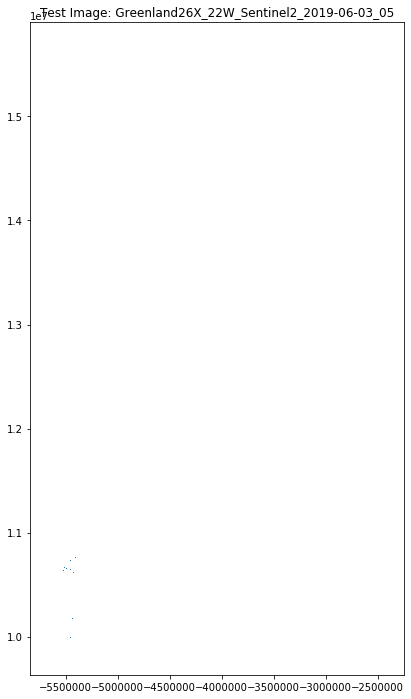

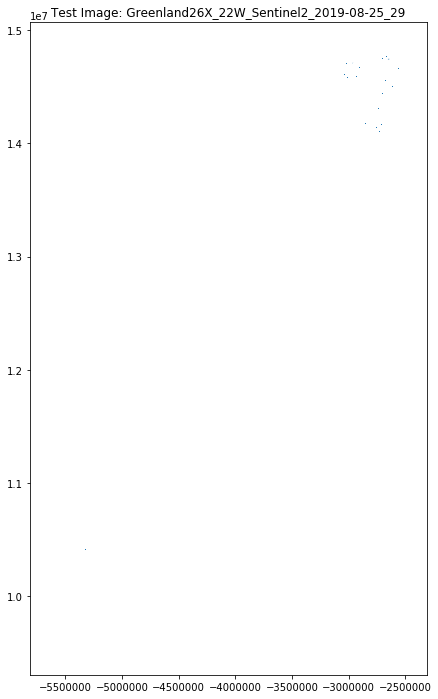

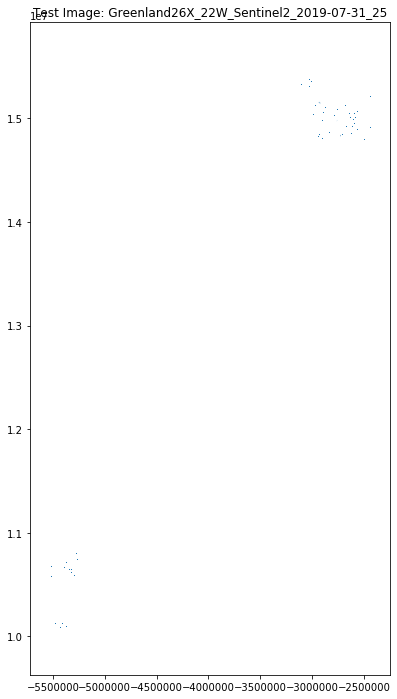

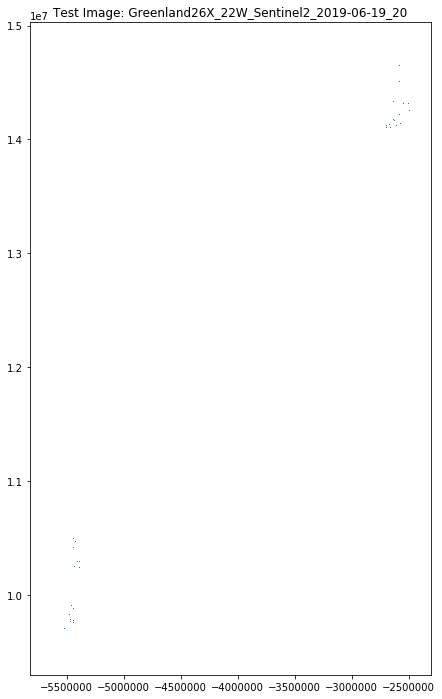

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the test GeoDataFrame containing all test polygons
test_gpkg = "lake_polygons_test.gpkg"
test_gdf = gpd.read_file(test_gpkg)

# Get unique image names from the test GeoDataFrame
unique_images = test_gdf["image"].unique()

# Create separate plots for each unique image
for image_name in unique_images:
    # Filter the GeoDataFrame for the current image
    image_gdf = test_gdf[test_gdf["image"] == image_name]

    # Plot the image
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_title(f"Test Image: {image_name}")
    # Plot the polygons on top of the image
    image_gdf.plot(ax=ax)

    # Optionally, you can save each plot to a file
    plt.savefig(f"test_image_{image_name}.png")

    # Show the plot for the current image
    plt.show()


Plot lake_polygons_training.gpkg

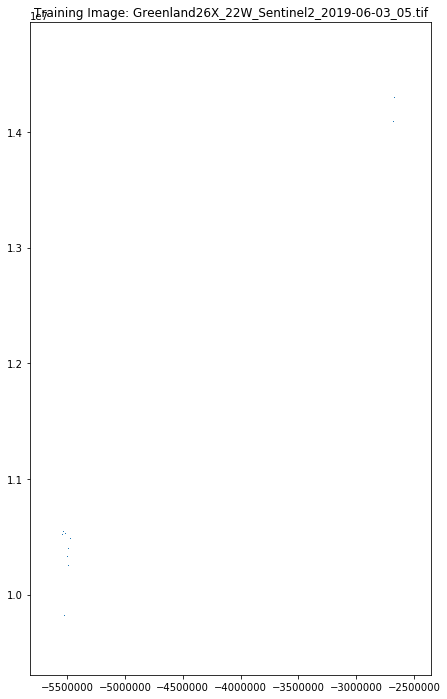

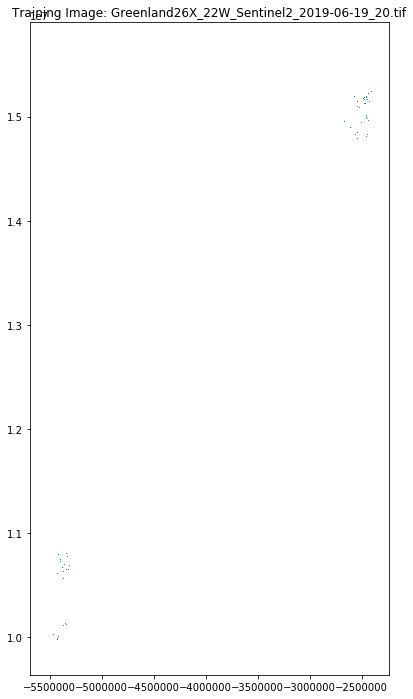

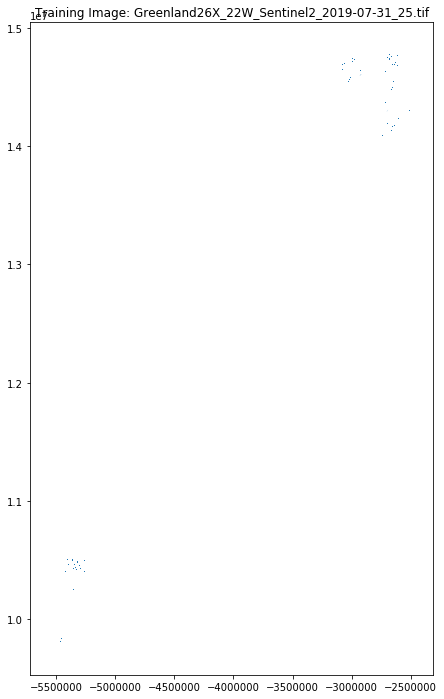

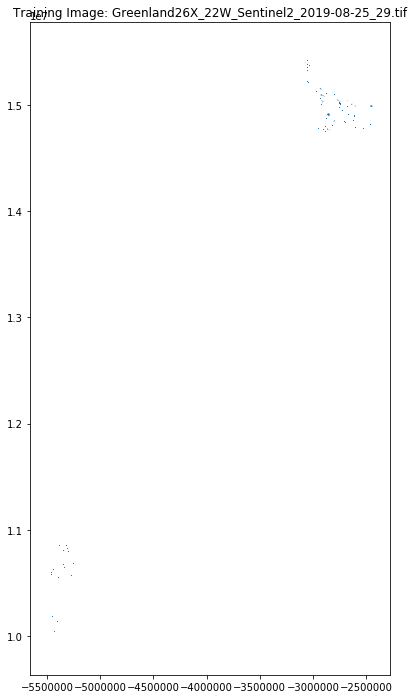

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the training GeoDataFrame containing all training polygons
training_gpkg = "lake_polygons_training.gpkg"
training_gdf = gpd.read_file(training_gpkg)

# Get unique image names from the training GeoDataFrame
unique_images = training_gdf["image"].unique()

# Create separate plots for each unique image
for image_name in unique_images:
    # Filter the GeoDataFrame for the current image
    image_gdf = training_gdf[training_gdf["image"] == image_name]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_title(f"Training Image: {image_name}")
    # Load and display the image here (e.g., using rasterio or another library)

    # Plot the polygons on top of the image
    image_gdf.plot(ax=ax)

    # Optionally, you can save each plot to a file
    plt.savefig(f"training_image_{image_name}.png")

    # Show the plot for the current image
    plt.show()



Extract 12 region from lake_polygons_test.gpkg" for a sanity check.

Overlay the extracted region with the projected images (Before and after making the test package)

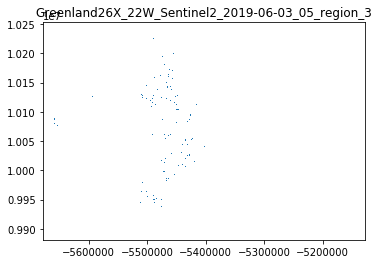

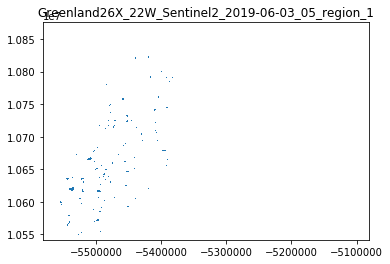

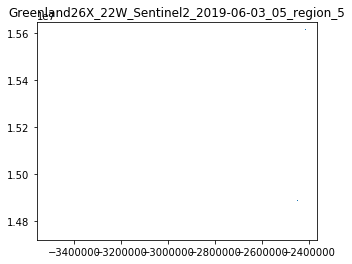

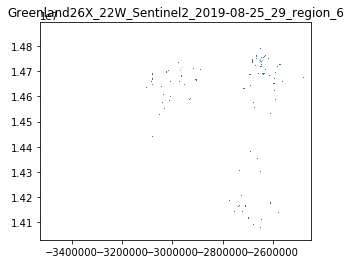

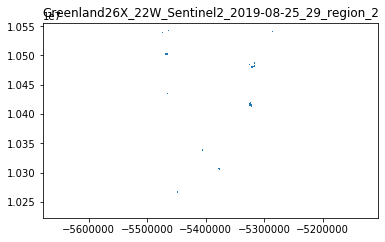

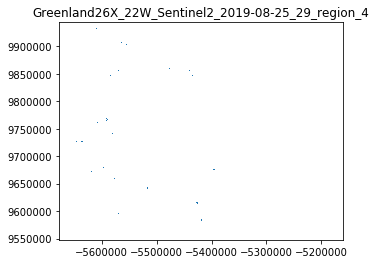

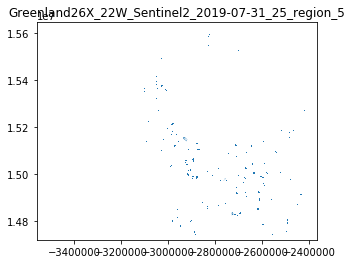

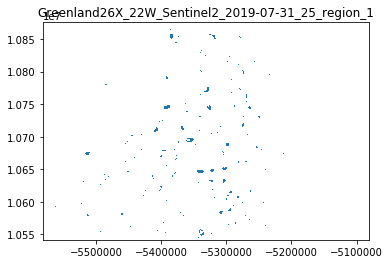

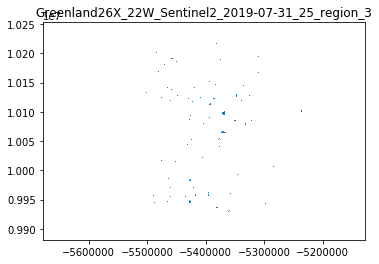

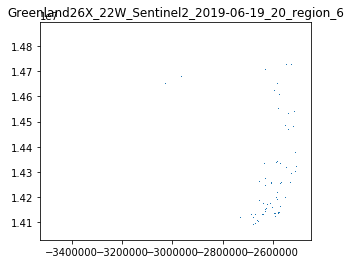

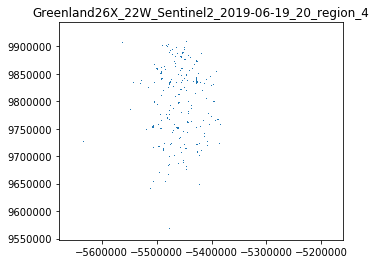

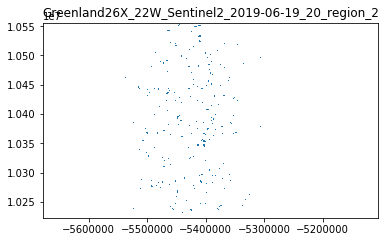

In [19]:


import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio

def plot_all_image_regions(gdf, raster_dir):
    # Loop through each unique image name
    for img_name in gdf['image'].unique():
        # For each image, loop through its unique regions
        for region in gdf[gdf['image'] == img_name]['region_num'].unique():
            filtered_gdf = gdf[(gdf['image'] == img_name) & (gdf['region_num'] == region)]
            
            if len(filtered_gdf) == 0:
                print(f"No polygons for {img_name} with region {region}")
                continue

            raster_path = os.path.join(raster_dir, f"{img_name}_region_{region}.tif")
            with rasterio.open(raster_path) as src:
                bounds = src.bounds

            fig, ax = plt.subplots()
            ax.set_xlim(bounds.left, bounds.right)
            ax.set_ylim(bounds.bottom, bounds.top)
            
            filtered_gdf.plot(ax=ax)
            plt.title(f"{img_name}_region_{region}")
            plt.show()

raster_directory = "projected_predicted_images"
gdf = gpd.read_file('lake_polygons_test.gpkg')
plot_all_image_regions(gdf, raster_directory)


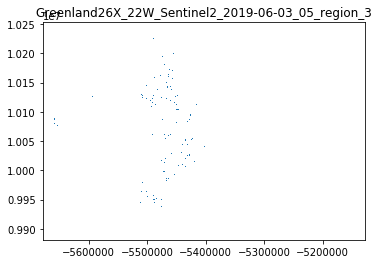

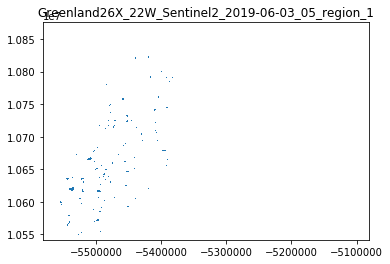

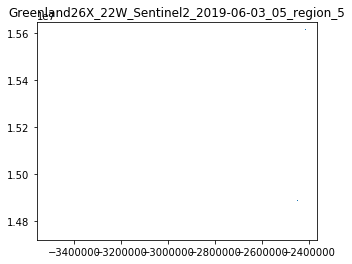

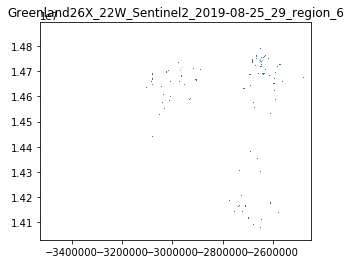

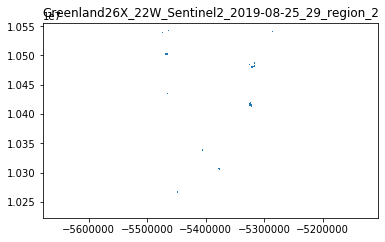

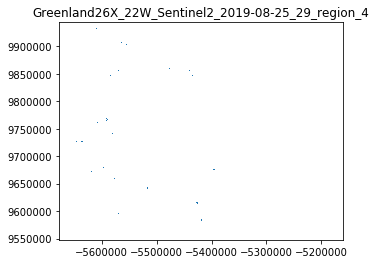

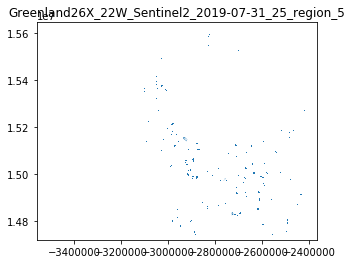

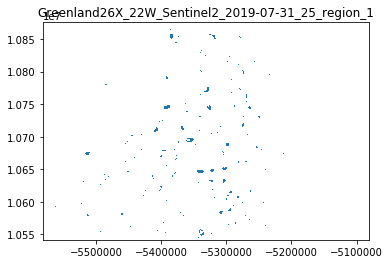

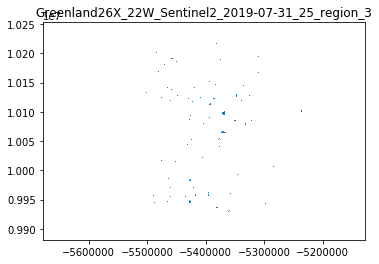

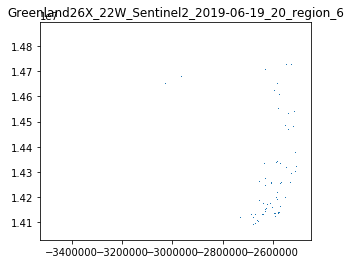

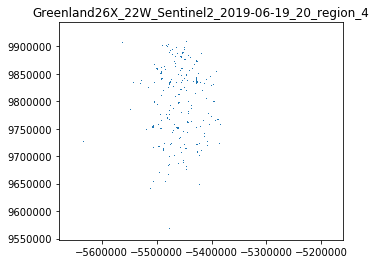

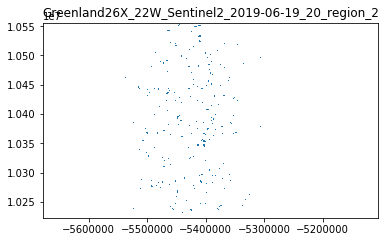

In [20]:

import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio

def plot_all_image_regions(gdf, raster_dir):
    # Loop through each unique image name
    for img_name in gdf['image'].unique():
        # For each image, loop through its unique regions
        for region in gdf[gdf['image'] == img_name]['region_num'].unique():
            filtered_gdf = gdf[(gdf['image'] == img_name) & (gdf['region_num'] == region)]
            
            if len(filtered_gdf) == 0:
                print(f"No polygons for {img_name} with region {region}")
                continue

            raster_path = os.path.join(raster_dir, f"{img_name}_region_{region}.tif")
            with rasterio.open(raster_path) as src:
                bounds = src.bounds

            fig, ax = plt.subplots()
            ax.set_xlim(bounds.left, bounds.right)
            ax.set_ylim(bounds.bottom, bounds.top)
            
            filtered_gdf.plot(ax=ax)
            plt.title(f"{img_name}_region_{region}")
            plt.show()

# Define the directory where the raster images are located
raster_directory = "test"
gdf = gpd.read_file('lake_polygons_test.gpkg')
plot_all_image_regions(gdf, raster_directory)


Overlay *an extracted region from  lake_polygons_test.gpkg with its projected image*, to see whether their coordinates are aligned (Before and after making the test package)overlay the extracted region with the projected images (Before and after making the test package)

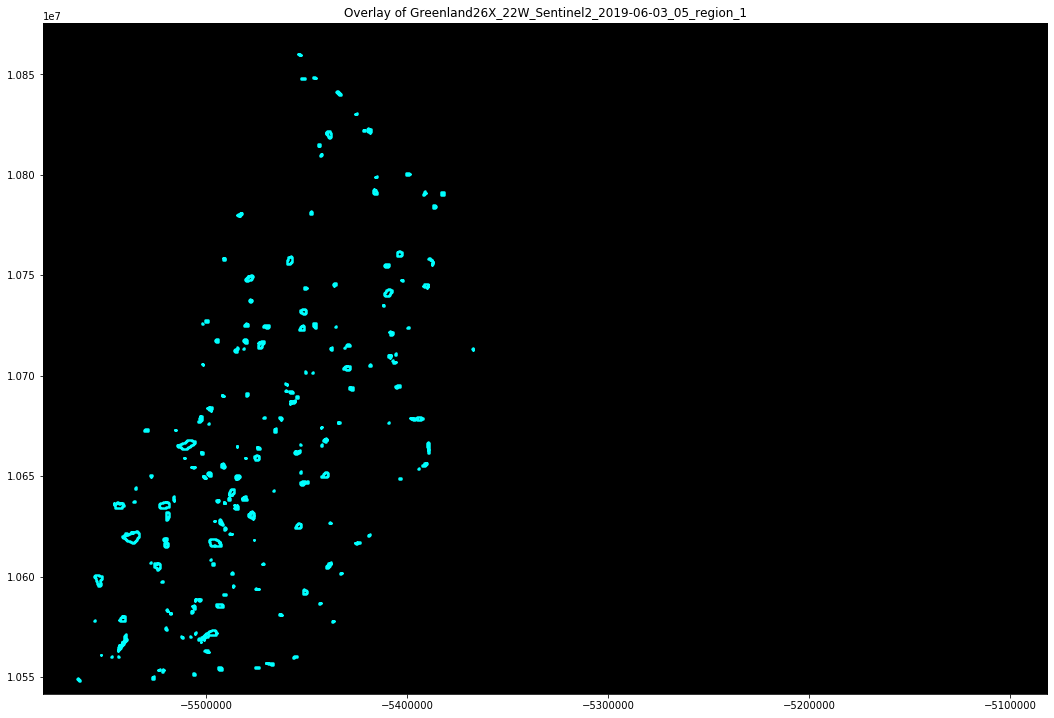

In [21]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

# Define paths
projected_raster_path = "projected_predicted_images_submission_5/Greenland26X_22W_Sentinel2_2019-06-03_05_region_1.tif"
geopackage_path = "lake_polygons_test.gpkg"


gdf = gpd.read_file(geopackage_path)

# Filtering the GeoDataFrame (You can skip this if you want to plot all polygons)
image_name = "Greenland26X_22W_Sentinel2_2019-06-03_05"
region_number = 1  # Assuming this is an integer in the dataset
filtered_gdf = gdf[(gdf['image'] == image_name) & (gdf['region_num'] == region_number)]

# Plotting
fig, ax = plt.subplots(figsize=(18,18))

# Plot the raster, converting white to black
with rasterio.open(projected_raster_path) as src:
    img_data = src.read(1)
    img_data[img_data == 255] = 0  # Convert white pixels to black
    show(img_data, ax=ax, transform=src.transform, cmap='gray')

# Overlay the polygons. Setting the boundary to be cyan and thicker for better visibility.
filtered_gdf.boundary.plot(ax=ax, color='cyan', linewidth=2.5)

plt.title(f"Overlay of {image_name}_region_{region_number}")
plt.show()


*Overlay an extracted region from  lake_polygons_test.gpkg with its original test image*, to see whether their coordinates are aligned (Before and after making the test package)overlay the extracted region with the projected images (Before and after making the test package)

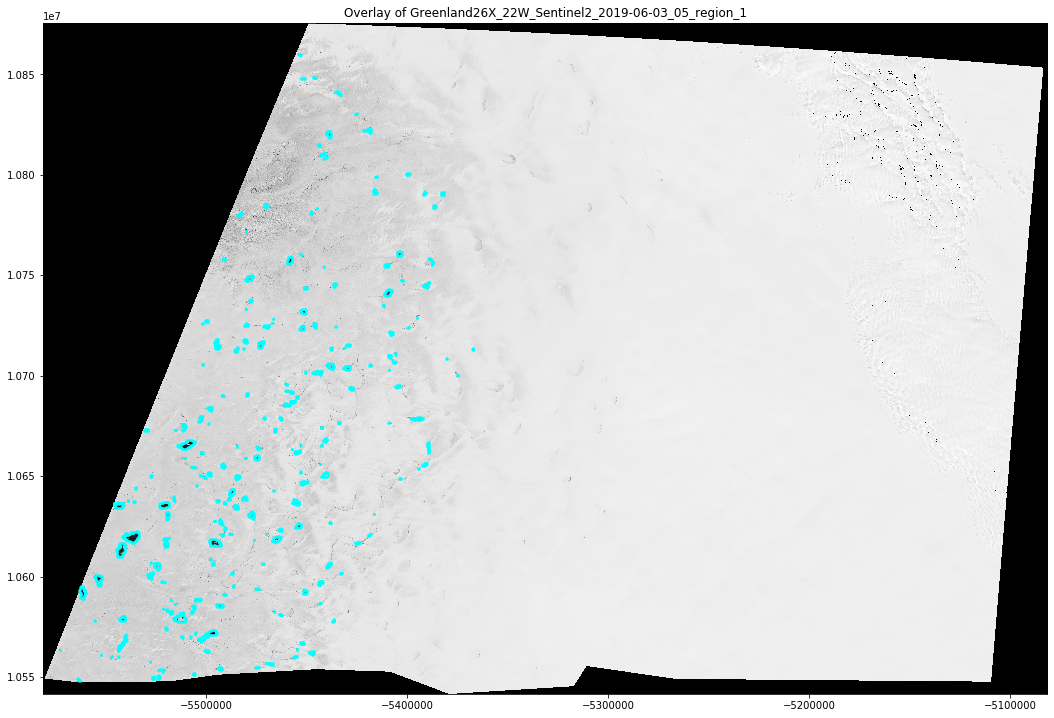

In [8]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

# Define paths
projected_raster_path = "test/Greenland26X_22W_Sentinel2_2019-06-03_05_region_1.tif"
geopackage_path = "lake_polygons_test.gpkg"


gdf = gpd.read_file(geopackage_path)

# Filtering the GeoDataFrame (You can skip this if you want to plot all polygons)
image_name = "Greenland26X_22W_Sentinel2_2019-06-03_05"
region_number = 1  # Assuming this is an integer in the dataset
filtered_gdf = gdf[(gdf['image'] == image_name) & (gdf['region_num'] == region_number)]

# Plotting
fig, ax = plt.subplots(figsize=(18,18))

# Plot the raster, converting white to black
with rasterio.open(projected_raster_path) as src:
    img_data = src.read(1)
    img_data[img_data == 255] = 0  # Convert white pixels to black
    show(img_data, ax=ax, transform=src.transform, cmap='gray')

# Overlay the polygons. Setting the boundary to be cyan and thicker for better visibility.
filtered_gdf.boundary.plot(ax=ax, color='cyan', linewidth=2.5)

plt.title(f"Overlay of {image_name}_region_{region_number}")
plt.show()
# Black Dots inside the Big Blue Dots: These are the predicted regions
#Big Blue Dots: These are the boundaries of the polygons

Validation steps

Validate Data Columns

In [366]:
loaded_gdf = gpd.read_file(output_test_gpkg)

# Check if required columns exist
if 'image' not in loaded_gdf.columns or 'region_num' not in loaded_gdf.columns:
    raise ValueError("Missing required columns in the GeoPackage!")

# Check if there are any empty/NA values in the 'image' and 'region_num' columns
if loaded_gdf['image'].isna().any() or loaded_gdf['region_num'].isna().any():
    raise ValueError("There are empty values in the required columns!")


 Validate Polygon Locations

In [314]:
train_regions_gdf = gpd.read_file("lakes_regions.gpkg")
for idx, row in loaded_gdf.iterrows():
    if not train_regions_gdf.intersects(row['geometry']).any():
        raise ValueError(f"Polygon with index {idx} does not intersect any training region!")


Validate Data Values

In [315]:
expected_regions = [1, 2, 3, 4, 5, 6]
expected_images = [
    "Greenland26X_22W_Sentinel2_2019-06-03_05",
    "Greenland26X_22W_Sentinel2_2019-06-19_20",
    "Greenland26X_22W_Sentinel2_2019-07-31_25",
    "Greenland26X_22W_Sentinel2_2019-08-25_29"
]

if not set(loaded_gdf['region_num']).issubset(expected_regions):
    raise ValueError("Unexpected values in 'region_num' column!")

if not set(loaded_gdf['image']).issubset(expected_images):
    raise ValueError("Unexpected values in 'image' column!")


In [241]:
import geopandas as gpd

# Load the train GeoPackage file
train_gpkg = "/home/in18657@ad.umbc.edu/lake/lake_polygons_training.gpkg"
train_gdf = gpd.read_file(train_gpkg)

# Display the structure and content of the train GeoDataFrame
print("Train GeoDataFrame Overview:")
print(train_gdf.info())
print("\nSample of the Train GeoDataFrame:")
print(train_gdf.head())

Train GeoDataFrame Overview:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   image       2919 non-null   object  
 1   region_num  2919 non-null   int64   
 2   geometry    2919 non-null   geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 68.5+ KB
None

Sample of the Train GeoDataFrame:
                                          image  region_num  \
0  Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
1  Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
2  Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
3  Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
4  Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   

                                            geometry  
0  POLYGON ((-5557392.360 10529124.209, -5557430....  
1  POLYGON ((-5515504.868 10233656.876, -5515543....  

In [243]:
import geopandas as gpd

# Load the train GeoPackage file
test_gpkg = "/home/in18657@ad.umbc.edu/lake/lake_polygons_test.gpkg"
test_gdf = gpd.read_file(test_gpkg)

# Display the structure and content of the train GeoDataFrame
print("Test GeoDataFrame Overview:")
print(train_gdf.info())
print("\nSample of the Test GeoDataFrame:")
print(train_gdf)

Test GeoDataFrame Overview:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   image       2919 non-null   object  
 1   region_num  2919 non-null   int64   
 2   geometry    2919 non-null   geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 68.5+ KB
None

Sample of the Test GeoDataFrame:
                                             image  region_num  \
0     Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
1     Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
2     Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
3     Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
4     Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
...                                            ...         ...   
2914  Greenland26X_22W_Sentinel2_2019-08-25_29.tif           5   
2915  Greenland26

In [204]:
unique_images = test_gdf["image"].unique()
unique_regions = test_gdf["region_num"].unique()
print(unique_images)
print(unique_regions)

['Greenland26X_22W_Sentinel2_2019-06-03_05'
 'Greenland26X_22W_Sentinel2_2019-08-25_29'
 'Greenland26X_22W_Sentinel2_2019-07-31_25'
 'Greenland26X_22W_Sentinel2_2019-06-19_20']
[3 6 1 5 2 4]


In [247]:
unique_images = train_gdf["image"].unique()
unique_regions = train_gdf["region_num"].unique()
print(unique_images)
print(unique_regions)

['Greenland26X_22W_Sentinel2_2019-06-03_05.tif'
 'Greenland26X_22W_Sentinel2_2019-06-19_20.tif'
 'Greenland26X_22W_Sentinel2_2019-07-31_25.tif'
 'Greenland26X_22W_Sentinel2_2019-08-25_29.tif']
[2 4 6 1 3 5]


In [77]:
print("CRS for training_gdf:", training_gdf.crs)
print("CRS for test_gdf:", test_gdf.crs)


CRS for training_gdf: EPSG:3857
CRS for test_gdf: EPSG:3857


In [292]:
# a sample image prediction
import rasterio

# Open the predicted image file with rasterio
with rasterio.open("projected_predicted_images/Greenland26X_22W_Sentinel2_2019-06-03_05_region_3.tif") as src:
    crs = src.crs

print(f"CRS of the predicted image: {crs}")


CRS of the predicted image: EPSG:3857


In [209]:
import geopandas as gpd

training_gdf = gpd.read_file("lake_polygons_training.gpkg")
testing_gdf = gpd.read_file("lake_polygons_test.gpkg")

# Check columns
assert list(training_gdf.columns) == list(testing_gdf.columns), "Columns do not match!"

# Check data types
for col in training_gdf.columns:
    assert training_gdf[col].dtype == testing_gdf[col].dtype, f"Data type mismatch for column {col}!"

# Check CRS
assert training_gdf.crs == testing_gdf.crs, "Coordinate reference systems do not match!"
print("Columns match!")


Columns match!


In [210]:
# Define the image_files variable using the list you provided
image_files = [
    'Greenland26X_22W_Sentinel2_2019-06-03_05_region_3.tif',
    'Greenland26X_22W_Sentinel2_2019-08-25_29_region_6.tif',
    'Greenland26X_22W_Sentinel2_2019-06-03_05_region_1.tif',
    'Greenland26X_22W_Sentinel2_2019-07-31_25_region_5.tif',
    'Greenland26X_22W_Sentinel2_2019-06-19_20_region_6.tif',
    'Greenland26X_22W_Sentinel2_2019-08-25_29_region_2.tif',
    'Greenland26X_22W_Sentinel2_2019-06-19_20_region_4.tif',
    'Greenland26X_22W_Sentinel2_2019-07-31_25_region_1.tif',
    'Greenland26X_22W_Sentinel2_2019-06-19_20_region_2.tif',
    'Greenland26X_22W_Sentinel2_2019-08-25_29_region_4.tif',
    'Greenland26X_22W_Sentinel2_2019-06-03_05_region_5.tif',
    'Greenland26X_22W_Sentinel2_2019-07-31_25_region_3.tif'
]

# Now, run the verification code using the above-defined image_files variable
image_region_pairs_test = [(name.split('_region_')[0], int(name.split('_region_')[1].split('.tif')[0])) for name in image_files]

# Expected test segments based on Table 3
expected_test_segments = {
    'Greenland26X_22W_Sentinel2_2019-06-03_05': [1, 3, 5],
    'Greenland26X_22W_Sentinel2_2019-06-19_20': [2, 4, 6],
    'Greenland26X_22W_Sentinel2_2019-07-31_25': [1, 3, 5],
    'Greenland26X_22W_Sentinel2_2019-08-25_29': [2, 4, 6]
}

for base_name, region in image_region_pairs_test:
    assert region in expected_test_segments[base_name], f"Unexpected region {region} for image {base_name}"

print("All test segments match the expected segments from Table 3!")


All test segments match the expected segments from Table 3!


In [212]:
test_segments = testing_gdf.groupby(['image', 'region_num']).size().reset_index().rename(columns={0:'count'})
print(f"Number of unique image-region segments in test data: {len(test_segments)}")


Number of unique image-region segments in test data: 12


In [9]:
# sanity check
import rasterio

# Specify the path to the GeoTIFF file
image_path ="projected_predicted_images/Greenland26X_22W_Sentinel2_2019-06-03_05_region_1.tif"

try:
    # Open the GeoTIFF file
    with rasterio.open(image_path) as src:
        # Check the metadata
        print("Image Metadata:")
        print(src.profile)

        # Read the image as a numpy array
        image = src.read()

    # Check if the image was successfully loaded
    if image is not None:
        print("Image loaded successfully.")
        print(f"Image shape: {image.shape}")
    else:
        print(f"Error loading image: {image_path}")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Image Metadata:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 13078, 'height': 8733, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(38.21851414258808, 0.0, -5581355.368355258,
       0.0, -38.21851414258808, 10875536.82144313), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
Image loaded successfully.
Image shape: (1, 8733, 13078)


In [10]:
import rasterio

# Specify the path to the GeoTIFF file
image_path ="test/Greenland26X_22W_Sentinel2_2019-06-03_05_region_1.tif"

try:
    # Open the GeoTIFF file
    with rasterio.open(image_path) as src:
        # Check the metadata
        print("Image Metadata:")
        print(src.profile)

        # Read the image as a numpy array
        image = src.read()

    # Check if the image was successfully loaded
    if image is not None:
        print("Image loaded successfully.")
        print(f"Image shape: {image.shape}")
    else:
        print(f"Error loading image: {image_path}")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Image Metadata:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 13078, 'height': 8733, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(38.21851414258808, 0.0, -5581355.368355258,
       0.0, -38.21851414258808, 10875536.82144313), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}
Image loaded successfully.
Image shape: (3, 8733, 13078)


**End of sanity check**

**Part 7: Plotting the prediction of 12 test areas with their original images**

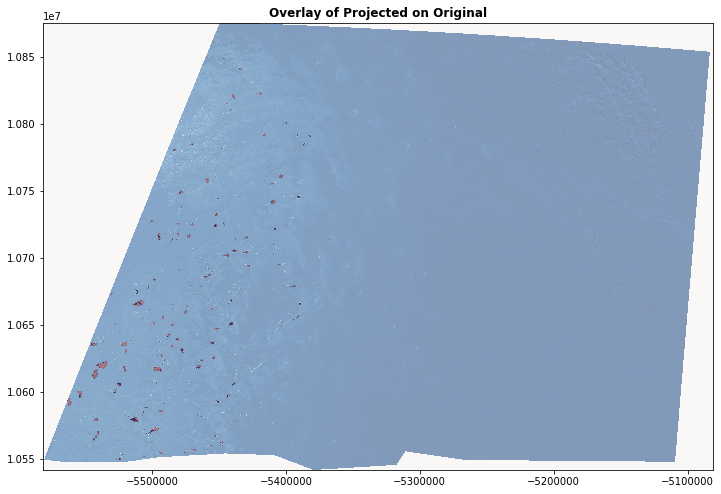

In [22]:
# overlay a prediction and an original test
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

# Paths to the original and projected raster files
original_raster_path = "test/Greenland26X_22W_Sentinel2_2019-06-03_05_region_1.tif"
projected_raster_path = "projected_predicted_images_submission_5/Greenland26X_22W_Sentinel2_2019-06-03_05_region_1.tif"

# Read the original raster
with rasterio.open(original_raster_path) as src:
    original_array = src.read(1)
    original_transform = src.transform

# Read the projected raster
with rasterio.open(projected_raster_path) as src:
    projected_array = src.read(1)
    projected_transform = src.transform

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# Show the original raster (in blue)
show(original_array, transform=original_transform, ax=ax, cmap='Blues', title='Overlay of Projected on Original')

# Overlay the projected raster (in red) with 50% transparency
show(projected_array, transform=projected_transform, ax=ax, cmap='Reds', alpha=0.5)

plt.show()


In [323]:
image_example = os.path.join(image_folder_path, image_files[0])
mask_example = os.path.join(mask_folder_path, mask_files[0])

with rasterio.open(image_example) as img_src, rasterio.open(mask_example) as mask_src:
    print("Image CRS:", img_src.crs)
    print("Image Bounds:", img_src.bounds)
    print("Mask CRS:", mask_src.crs)
    print("Mask Bounds:", mask_src.bounds)


Image CRS: EPSG:3857
Image Bounds: BoundingBox(left=-5678009.990621864, bottom=9881320.394537844, right=-5127128.327770599, top=10252919.007546227)
Mask CRS: EPSG:3857
Mask Bounds: BoundingBox(left=-5581355.368355258, bottom=10541774.537435908, right=-5081533.640398491, top=10875536.82144313)


**End of part 7**

**Part 8:Post processing**

**Overlap check**
The below code identify and print out any image-region combinations where overlapping polygons exist



In [317]:
import geopandas as gpd


unique_image_regions = test_gdf[['image', 'region_num']].drop_duplicates().to_dict('records')

for entry in unique_image_regions:
    subset_gdf = test_gdf[(test_gdf['image'] == entry['image']) & (test_gdf['region_num'] == entry['region_num'])]

    # Check for overlaps: This will find polygons in subset_gdf that overlap with others in the same subset
    overlaps = gpd.sjoin(subset_gdf, subset_gdf, predicate='overlaps')

    if not overlaps.empty:
        print(f"Found overlaps in image {entry['image']} for region {entry['region_num']}.")



In [8]:
def count_polygons_in_mask(mask_path):
    with rasterio.open(mask_path) as src:
        mask_data = src.read(1).astype(np.uint8)  # Convert mask to uint8
        
        # Assuming lakes are represented by non-zero value, converting True to 1 and False to 0
        mask = (mask_data > 0).astype(np.uint8)

        count = 0
        for feature, value in shapes(mask, transform=src.transform):
            if value == 1:
                count += 1
        
        return count

mask_directory = "/home/in18657@ad.umbc.edu/lake/mask"
total_polygons = 0

for mask_file in os.listdir(mask_directory):
    if mask_file.endswith(".tif"):
        mask_path = os.path.join(mask_directory, mask_file)
        polygons_count = count_polygons_in_mask(mask_path)
        print(f"Number of polygons in {mask_file}: {polygons_count}")
        total_polygons += polygons_count

print(f"Total count of polygons for all images: {total_polygons}")


Number of polygons in Greenland26X_22W_Sentinel2_2019-07-31_25.tif_mask_region_2.tif: 330
Number of polygons in Greenland26X_22W_Sentinel2_2019-06-19_20.tif_mask_region_3.tif: 323
Number of polygons in Greenland26X_22W_Sentinel2_2019-06-03_05.tif_mask_region_2.tif: 388
Number of polygons in Greenland26X_22W_Sentinel2_2019-06-03_05.tif_mask_region_4.tif: 338
Number of polygons in Greenland26X_22W_Sentinel2_2019-07-31_25.tif_mask_region_6.tif: 263
Number of polygons in Greenland26X_22W_Sentinel2_2019-06-19_20.tif_mask_region_1.tif: 199
Number of polygons in Greenland26X_22W_Sentinel2_2019-06-03_05.tif_mask_region_6.tif: 52
Number of polygons in Greenland26X_22W_Sentinel2_2019-08-25_29.tif_mask_region_5.tif: 184
Number of polygons in Greenland26X_22W_Sentinel2_2019-07-31_25.tif_mask_region_4.tif: 50
Number of polygons in Greenland26X_22W_Sentinel2_2019-06-19_20.tif_mask_region_5.tif: 664
Number of polygons in Greenland26X_22W_Sentinel2_2019-08-25_29.tif_mask_region_3.tif: 54
Number of pol

In [ ]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.features import shapes

import geopandas as gpd

# Load polygons from test.gpkg
test_gdf = gpd.read_file("lake_polygons_test.gpkg")

# Group by image and region and count number of polygons for each group
polygon_counts = test_gdf.groupby(['image', 'region_num']).size().reset_index(name='num_polygons')

for _, row in polygon_counts.iterrows():
    print(f"Image: {row['image']}, Region: {row['region_num']}, Number of polygons: {row['num_polygons']}")



Image: Greenland26X_22W_Sentinel2_2019-06-03_05, Region: 1, Number of polygons: 290
Image: Greenland26X_22W_Sentinel2_2019-06-03_05, Region: 3, Number of polygons: 341
Image: Greenland26X_22W_Sentinel2_2019-06-03_05, Region: 5, Number of polygons: 46
Image: Greenland26X_22W_Sentinel2_2019-06-19_20, Region: 2, Number of polygons: 875
Image: Greenland26X_22W_Sentinel2_2019-06-19_20, Region: 4, Number of polygons: 664
Image: Greenland26X_22W_Sentinel2_2019-06-19_20, Region: 6, Number of polygons: 706
Image: Greenland26X_22W_Sentinel2_2019-07-31_25, Region: 1, Number of polygons: 395
Image: Greenland26X_22W_Sentinel2_2019-07-31_25, Region: 3, Number of polygons: 340
Image: Greenland26X_22W_Sentinel2_2019-07-31_25, Region: 5, Number of polygons: 1610
Image: Greenland26X_22W_Sentinel2_2019-08-25_29, Region: 2, Number of polygons: 38
Image: Greenland26X_22W_Sentinel2_2019-08-25_29, Region: 4, Number of polygons: 79
Image: Greenland26X_22W_Sentinel2_2019-08-25_29, Region: 6, Number of polygons